# Usability Improvements on Desktop AB Test Report

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** Last update: 27 June 2023**

[TASK](https://phabricator.wikimedia.org/T302358)| [CODEBASE](https://gitlab.wikimedia.org/mneisler/usability-improvements-desktop-analysis-2023/-/tree/main)

# Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)
3. [Revert Rate](#Revert-Rate)
4. [Edit Completion Rate](#Edit-Completion-Rate)
5. [Average time duration from Junior Contributor viewing a desktop talk page to engagement](#Average-time-duration-from-Junior-Contributor-viewing-a-desktop-talk-page-to-engagement)
6. [Proportion of Junior Contributors that visit a talk page and engage with the page](#Proportion-of-Junior-Contributors-that-visit-a-talk-page-and-engage-with-the-page)
7. [Proportion of Junior Contributors who click an affordance on a talk page and successfully publish an edit](#Proportion-of-Junior-Contributors-who-click-an-affordance-on-a-talk-page-and-successfully-publish-an-edit)
8. [Average time duration from Senior Contributor viewing a desktop talk page to engagement](#Average-time-duration-from-Senior-Contributor-viewing-a-desktop-talk-page-to-engagement)


# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time. 

As part of this effort, the Editing team is evaluating the impact of a set of changes to the visual appearance of talk pages including topic containers, clearer talking affordances, and page framing.

By making the components that comprise talk pages conversations and the tools necessary for participating in them easier for people to parse, we are striving to:

* Increase the likelihood Junior Contributors quickly recognize talk pages as spaces to communicate with other volunteers and locate the tools available to do so and
* Increase the likelihood Senior Contributors can quickly evaluate the level of activity happening on talk pages.


The team ran an AB test of Usability Improvements on Desktop from 8 May 2023 through 28 May 2023. The test included all logged-in users that viewed a desktop talk page skin at one the 15 participating Wikipedias during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T332946) and conditions outlined in the methodology section below).

The results of the A/B test will help us make the following decision: Are the set of Usability Improvements on desktop fit to be made available to everyone, at all Wikimedia wikis, by default?

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/w/index.php?title=Talk_pages_project/Usability&useskin=vector-2022).


# Methodology

The AB test was run on a per Wikipedia basis and included all logged-in contributors accessing a desktop talk page on any of the Participating wikis. Contributors included in the test have a 50% chance of being assigned to either the control group or test groups. In the test group, users are shown the set of visual talk page usability improvements. In the control group, users are shown talk pages without the set of usability improvmements.

Once assigned a group, users remained in the same group they were bucketed in for the duration of the test.

We reviewed AB test data recorded from 08 May 2023 through 28 May 2023 for this analysis.  Edit attempts were collected in [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/). We also reviewed desktop talk page views. This data was logged in the [DesktioWebUIActionTracking](https://schema.wikimedia.org/repositories/secondary/jsonschema/analytics/legacy/desktopwebuiactionstracking/current.yaml) schema.

For each metric, we reviewed the following dimensions: overall, by editing interface, by editor experience, by desktop skin type, and by participating Wikipedia.

Bucketing Notes/Issues: 
* We were unable to include logged-out users in this test. Due to CDN caching issues, bucketing assignment for logged-out users can only be done on a per-page basis, aS a result, the buckets for anon users just refers to the initial presentation of the page and could not reliably determine the talk page version displayed to logged-out users based on their assigned bucket.
* We did not review data logged after 5/28 due to a bug that resulted in the editing button to go missing in the sticky header for 7 of the wikis in our ab test including: Hebrew Wikipedia, Persian Wikipedia, Korean Wikipedia, Portuguese Wikipedia, Thai Wikipedia, Turkish and Vietnamese Wikipedia. 

See the following Phabricator tickets for further details regarding instrumentation and implementation of the AB test:

* Identify Wikis: [T332946](https://phabricator.wikimedia.org/T332946)
* Implement Bucketing: [T333715](https://phabricator.wikimedia.org/T333715)

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(glue)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [2]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

# Revert Rate

Defined at the proportion of published talk page edits, of all types, that are reverted within 48 hours. This was identifed as one of the two Key Peformance Indicators for this analysis.


In [3]:
revert_data <-
  read.csv(
    file = 'Data/revert_data_ab.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [4]:
#Reformat date
revert_data$date <- as.Date(revert_data$date, format = "%Y-%m-%d")

#clarfiy levels and labels for factor variables

revert_data$is_reverted <-
  factor(revert_data$is_reverted,
         levels = c("reverted", "not-reverted"),
         labels = c("Reverted", "Not reverted"))

#reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
revert_data$user_id <-
  as.character(paste(revert_data$user_id,revert_data$wiki,sep ="-" ))

#clarfiy wiki names
revert_data <- revert_data %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
      wiki == 'kowiki' ~ "Korean Wikipedia", 
      wiki == 'viwiki' ~ "Vietnamese Wikipedia",
      wiki == 'dewiki' ~ "German Wikipedia",
    )
  ) 
    

# group user edit count 
revert_data <- revert_data %>%
 mutate(
    initial_edit_count = case_when(
      initial_edit_count  < 100  ~ "under 100",
      initial_edit_count  >= 100 ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
revert_data$initial_edit_count <-
  factor(revert_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))


# fix inteface field to include
revert_data  <- revert_data%>%
  mutate(
    editor_interface = case_when (#clarfiy interface which matches mediawiki_editattempt_block schema
        integration=='discussiontools'  ~ 'discussiontools' ,
        integration=='page' & interface=='wikitext' ~ 'wikieditor' ,
        integration=='page' & interface=='visualeditor'  ~ 'visualeditor' ,
        integration=='page' & interface=='wikitext-2017'  ~ 'visualeditor',
        TRUE ~ 'Unknown' )
 )

## Overall

In [5]:
revert_rate_overall <- revert_data %>%
   # filter(wiki != 'Hindi Wikipedia') %>%
    group_by(experiment_group) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3))

revert_rate_overall 

experiment_group n_edits n_reverts revert_rate
1 control          7306    253       0.035      
2 test             8677    271       0.031

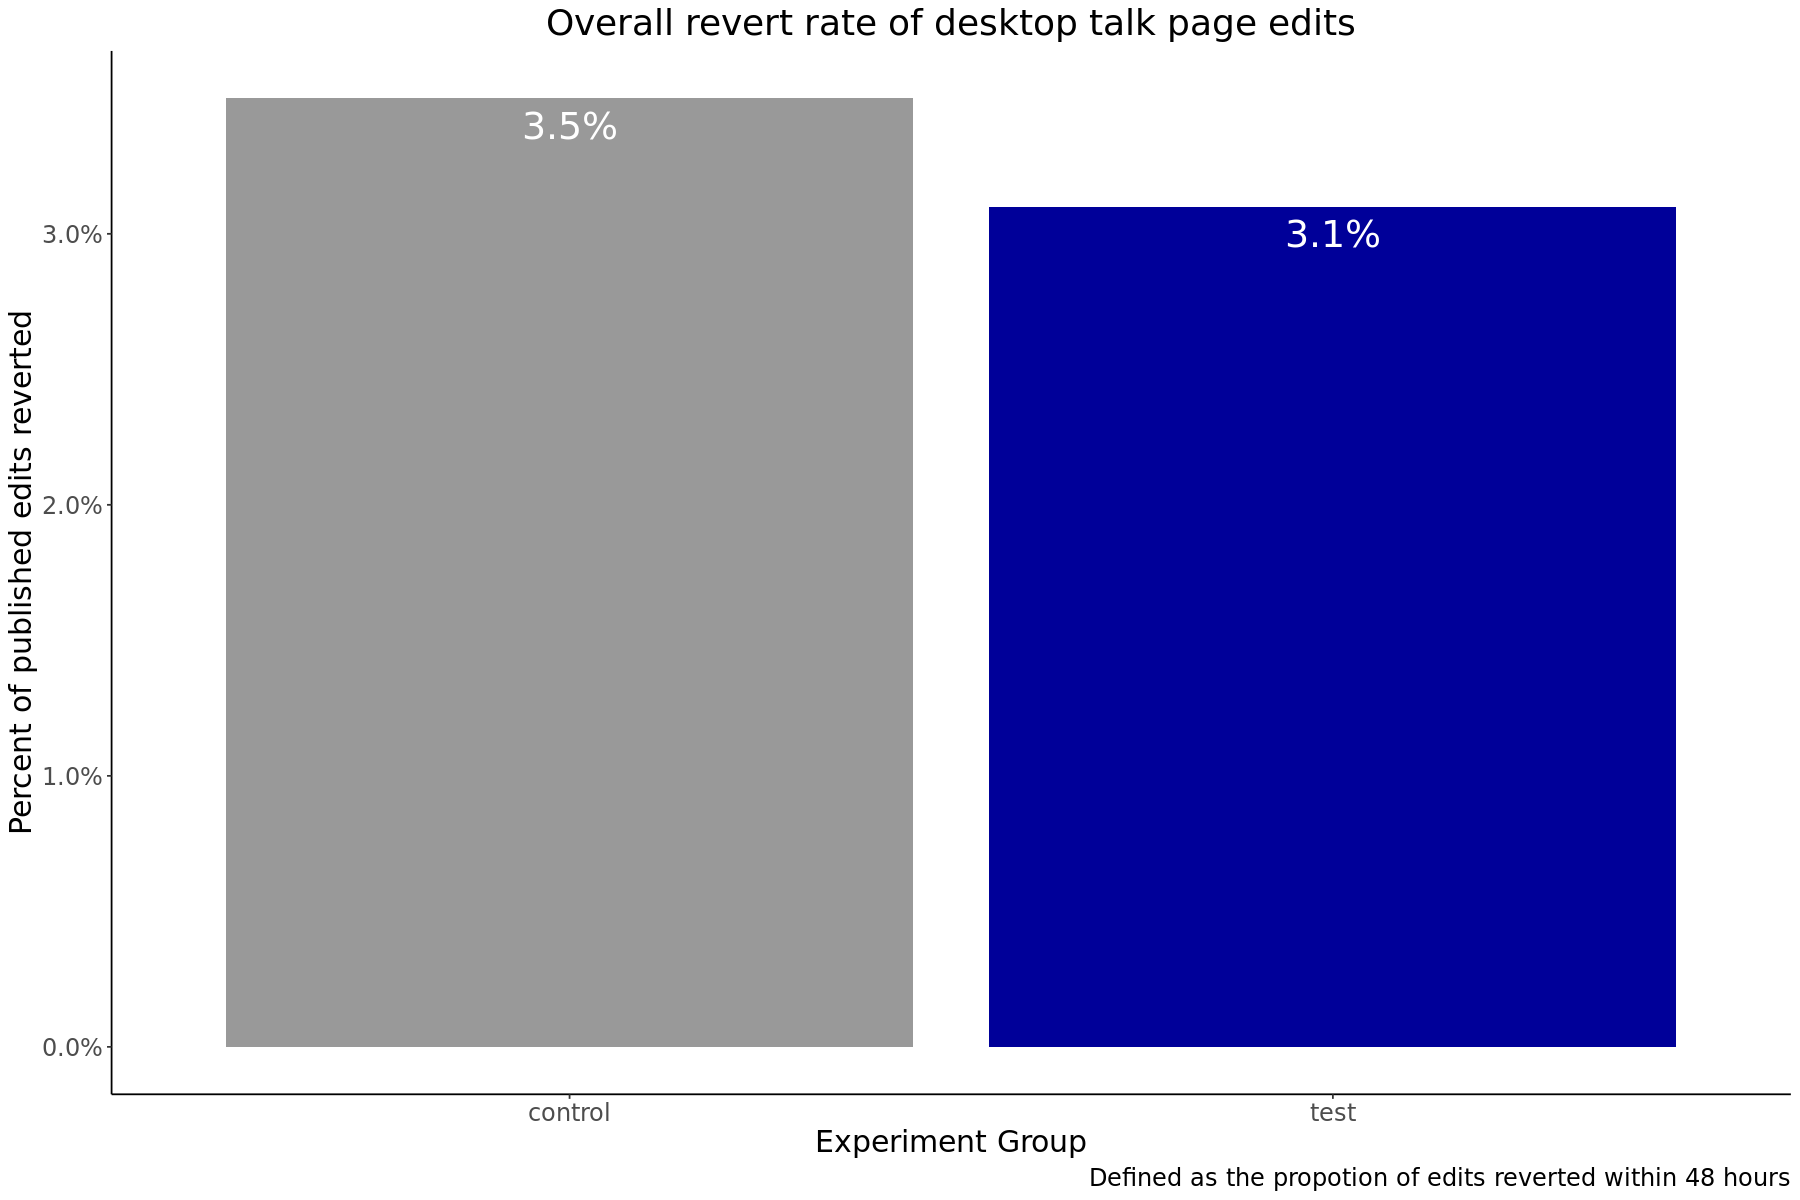

In [6]:

p <- revert_rate_overall  %>%
        ggplot(aes(x = experiment_group, y= revert_rate, fill = experiment_group)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(revert_rate * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment Group",
              y = "Percent of published edits reverted",
             title = "Overall revert rate of desktop talk page edits",
             caption = "Defined as the propotion of edits reverted within 48 hours") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/revert_rate_overall .png", p, width = 10, height = 8, units = "in", dpi = 300) 

We observed an 11% decrease (-0.4 percentage points) in the revert rate of talk page edits by users shown the set of usability improvements across all participating Wikipedias and all editor experience levels.

This includes the revert rate on Hindi Wikipedia, where there was an abnormally high 26.6% revert rate for the test group due to an external event on 19 May 2023, which is driving the revert rate up. If this Wikipedia is excluded, the revert rate of the test group decreases to  2.8% (a 20% decrease [-0.7 percentage points])

## By Eding Interface

In [24]:
revert_rate_byinterface <- revert_data %>%
    group_by(experiment_group, integration) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3))


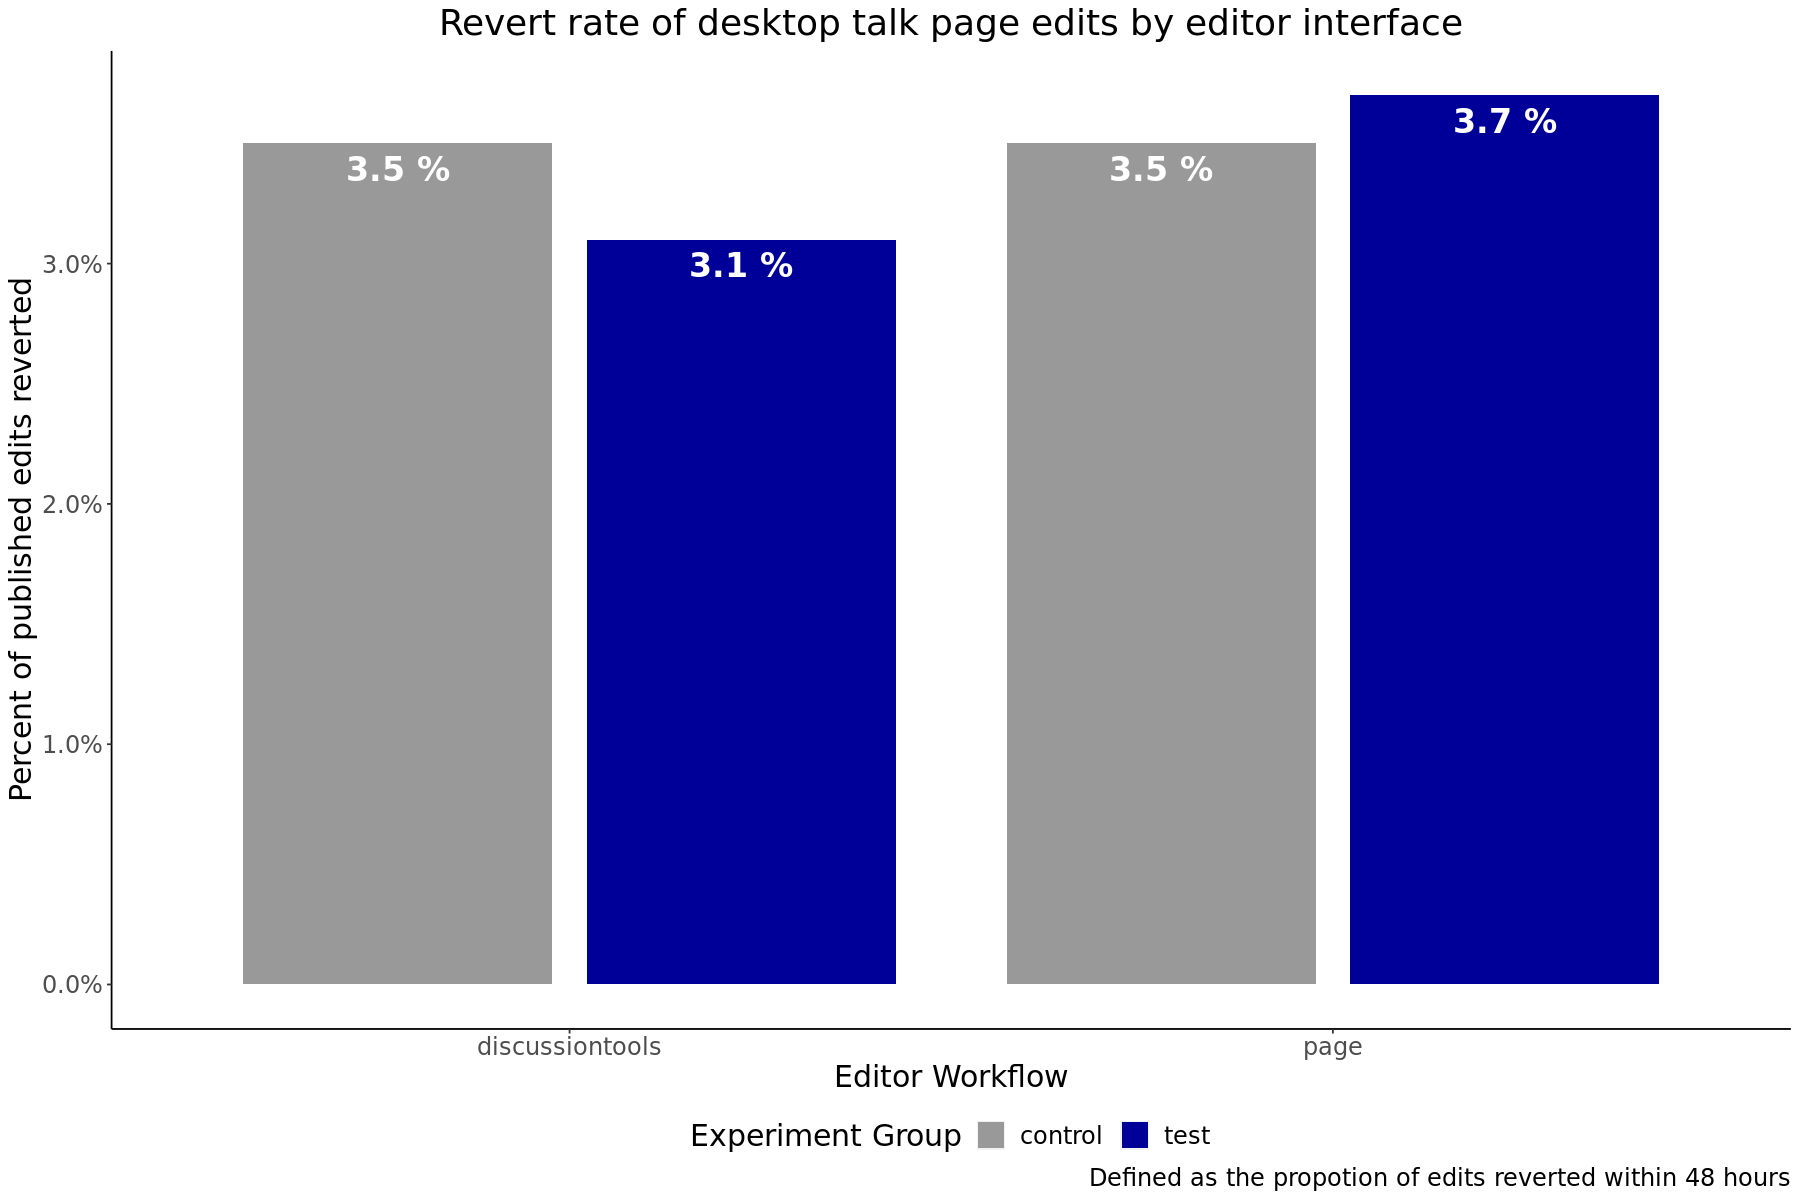

In [8]:


p <- revert_rate_byinterface   %>%
        ggplot(aes(x = integration, y= revert_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor Workflow",
              y = "Percent of published edits reverted",
             title = "Revert rate of desktop talk page edits by editor interface",
             caption = "Defined as the propotion of edits reverted within 48 hours") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
        guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/revert_rate_byinterface.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## By Editor Experience Level

In [22]:
revert_rate_byexp <- revert_data %>%
    group_by(experiment_group, initial_edit_count) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3))

revert_rate_byexp

experiment_group initial_edit_count n_edits n_reverts revert_rate
1 control          under 100          1249     90       0.072      
2 control          100+ edits         6057    163       0.027      
3 test             under 100          1466     93       0.063      
4 test             100+ edits         7211    178       0.025

In [10]:
# Plot search sessions initiated by pre and post deployment

p <- revert_rate_byexp   %>%
        ggplot(aes(x = initial_edit_count, y= revert_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor experience",
              y = "Percent of published edits reverted",
             title = "Revert rate of desktop talk page edits published by editor experience") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/revert_rate_byexp.png", p, width = 10, height = 8, units = "in", dpi = 300) 

There was a slightly higher decrease (-12.5% decrease) in revert rate for talk page edits by Junior Contributors compared to talk page edits by Senior Contributors (-7.4% decrease in revert rate)

## By Desktop Skin Type

In [11]:
revert_rate_byskin <- revert_data %>%
    group_by(experiment_group, skin) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3))


In [12]:


p <- revert_rate_byskin   %>%
        ggplot(aes(x = skin, y= revert_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Desktop skin",
              y = "Percent of published edits reverted",
             title = "Revert rate of talk page edits by desktop skin type") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
      guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/revert_rate_byskin.png", p, width = 10, height = 8, units = "in", dpi = 300) 

Different trends were observed when broken down by desktop skin type.
Vector: 6% increase in revert rate (3.2% → 3.4%)
Vector 2022: -30% decrease in revert rate (3.9% → 2.7%)

## By Wiki

In [13]:
revert_rate_bywiki <- revert_data %>%
    group_by(wiki, experiment_group) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3)) %>%
    arrange(wiki)


In [14]:

p <- revert_rate_bywiki    %>%
        filter(wiki != 'Thai Wikipedia')  %>%
        ggplot(aes(x = experiment_group, y= revert_rate, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(revert_rate * 100,"%"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki, scale = "free_y") +
        labs (x = "Desktop skin",
              y = "Percent of published edits reverted",
             title = "Revert rate of desktop talk page edits by participating wiki",
          caption = "Thai Wikipedia did not have any sufficient published edits during the reviewed timeframe to include in analysis") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/revert_rate_bywiki.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## Revert Rate Daily Trends at Hindi Wikipedia

In [19]:
revert_rate_byday_hiwiki <- revert_data %>%
    filter(wiki == 'Hindi Wikipedia',
          experiment_group == 'test') %>% #limit to where the majority of these events occurred
    group_by(date) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = round(n_reverts/n_edits, 3))


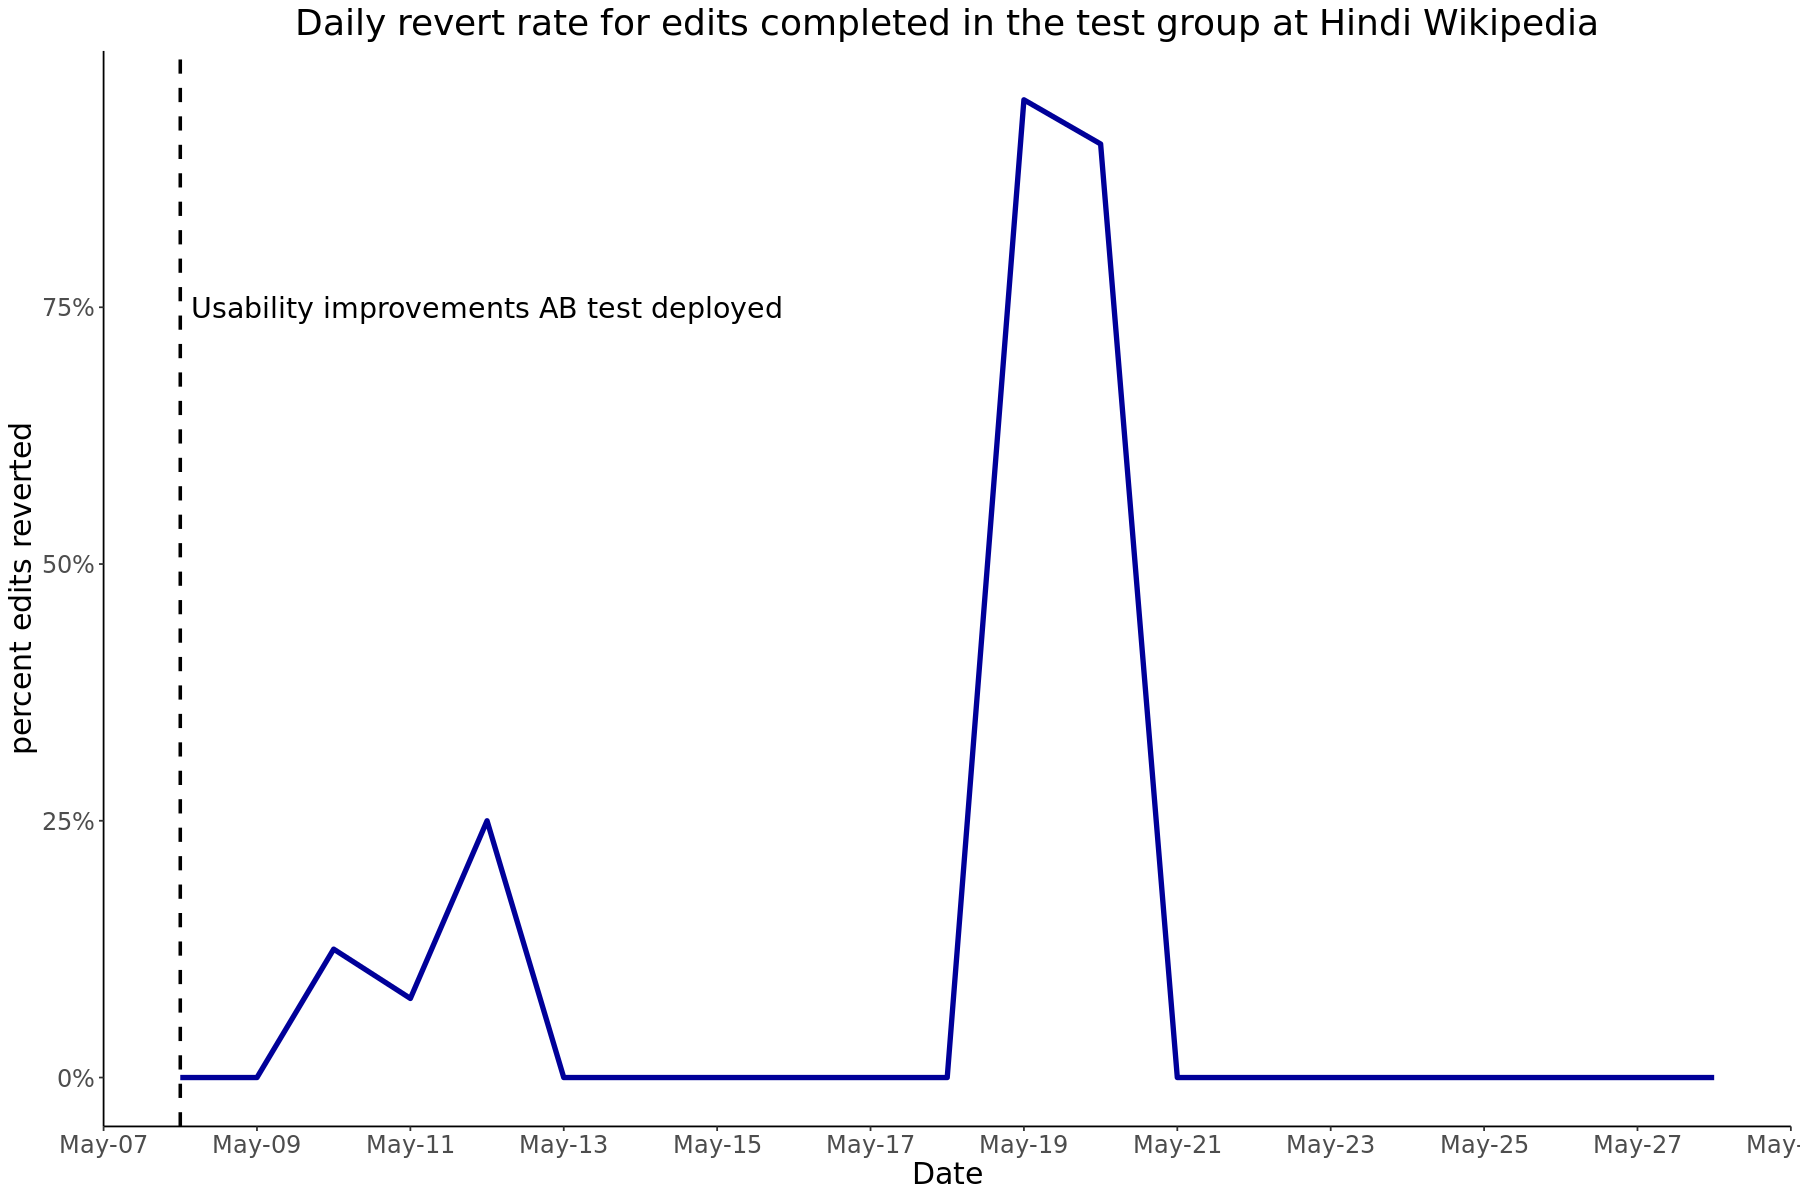

In [21]:
# plot daily sessions 

textaes <- data.frame(y = c(0.75),
                      x = as.Date('2023-05-12'),
                      lab = 'Usability improvements AB test deployed')

p <- revert_rate_byday_hiwiki %>%
    ggplot(aes(x= date, y = revert_rate)) +    
    geom_line(size =1.5, color = '#000099') +
    geom_vline(xintercept = as.Date('2023-05-08'), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 6) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "2 days", date_labels = "%b-%d") +
  labs(title = "Daily revert rate for edits completed in the test group at Hindi Wikipedia",
      y = "percent edits reverted",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/revert_rate_hiwiki_daily.png", p, width = 16, height = 8, units = "in", dpi = 300)

Further investigation indicates that this revert rate was caused by a single incident on 19-20 May 2023 during the AB test. Revert rates at Hindi Wikipedia have since stablized.

# Edit Completion Rate 

Defined as the proportion of talk page edits that are started and successfully published (not reverted within 48 hours). This was also identified as a KPI in this analysis.

In [53]:
edit_completion_data <-
  read.csv(
    file = 'Data/edit_completion_data_ab.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all edit completion rate data

In [54]:
# data reformatting and cleanup

#set factor levels with correct baselines

edit_completion_data$edit_success <-
  factor(
    edit_completion_data$edit_success,
    levels = c(0, 1),
    labels = c("Not Complete", "Complete")
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
edit_completion_data$user_id <-
  as.character(paste(edit_completion_data$user_id, edit_completion_data$wiki, sep ="-"))

#clarfiy wiki names
edit_completion_data <- edit_completion_data %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
      wiki == 'kowiki' ~ "Korean Wikipedia", 
      wiki == 'viwiki' ~ "Vietnamese Wikipedia",
      wiki == 'dewiki' ~ "German Wikipedia",
    )
  ) 
    
# group user edit count 
edit_completion_data <- edit_completion_data  %>%
 mutate(
    initial_edit_count = case_when(
     initial_edit_count < 100  ~ "under 100",
    initial_edit_count >= 100 ~ '100+ edits'  
    )
  ) 


# add factor levels to exp level
edit_completion_data$initial_edit_count <-
  factor(edit_completion_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))

# fix interface field 
edit_completion_data <- edit_completion_data%>%
  mutate(
    editor_interface = case_when (#clarfiy interface which matches mediawiki_editattempt_block schema
        integration=='discussiontools'  ~ 'discussiontools' ,
        integration=='page' & interface=='wikitext' ~ 'wikieditor' ,
        integration=='page' & interface=='visualeditor'  ~ 'visualeditor' ,
        integration=='page' & interface=='wikitext-2017'  ~ 'visualeditor',
        TRUE ~ 'Unknown' )
 )

## Overall

In [155]:
edit_completion_rate_overall <- edit_completion_data %>%
    group_by (experiment_group) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete' & edit_reverted == 0]),
              completion_rate = round(n_saves/n_attempts,3))

edit_completion_rate_overall

experiment_group n_attempts n_saves completion_rate
1 control          11487      7059    0.615          
2 test             13252      8410    0.635

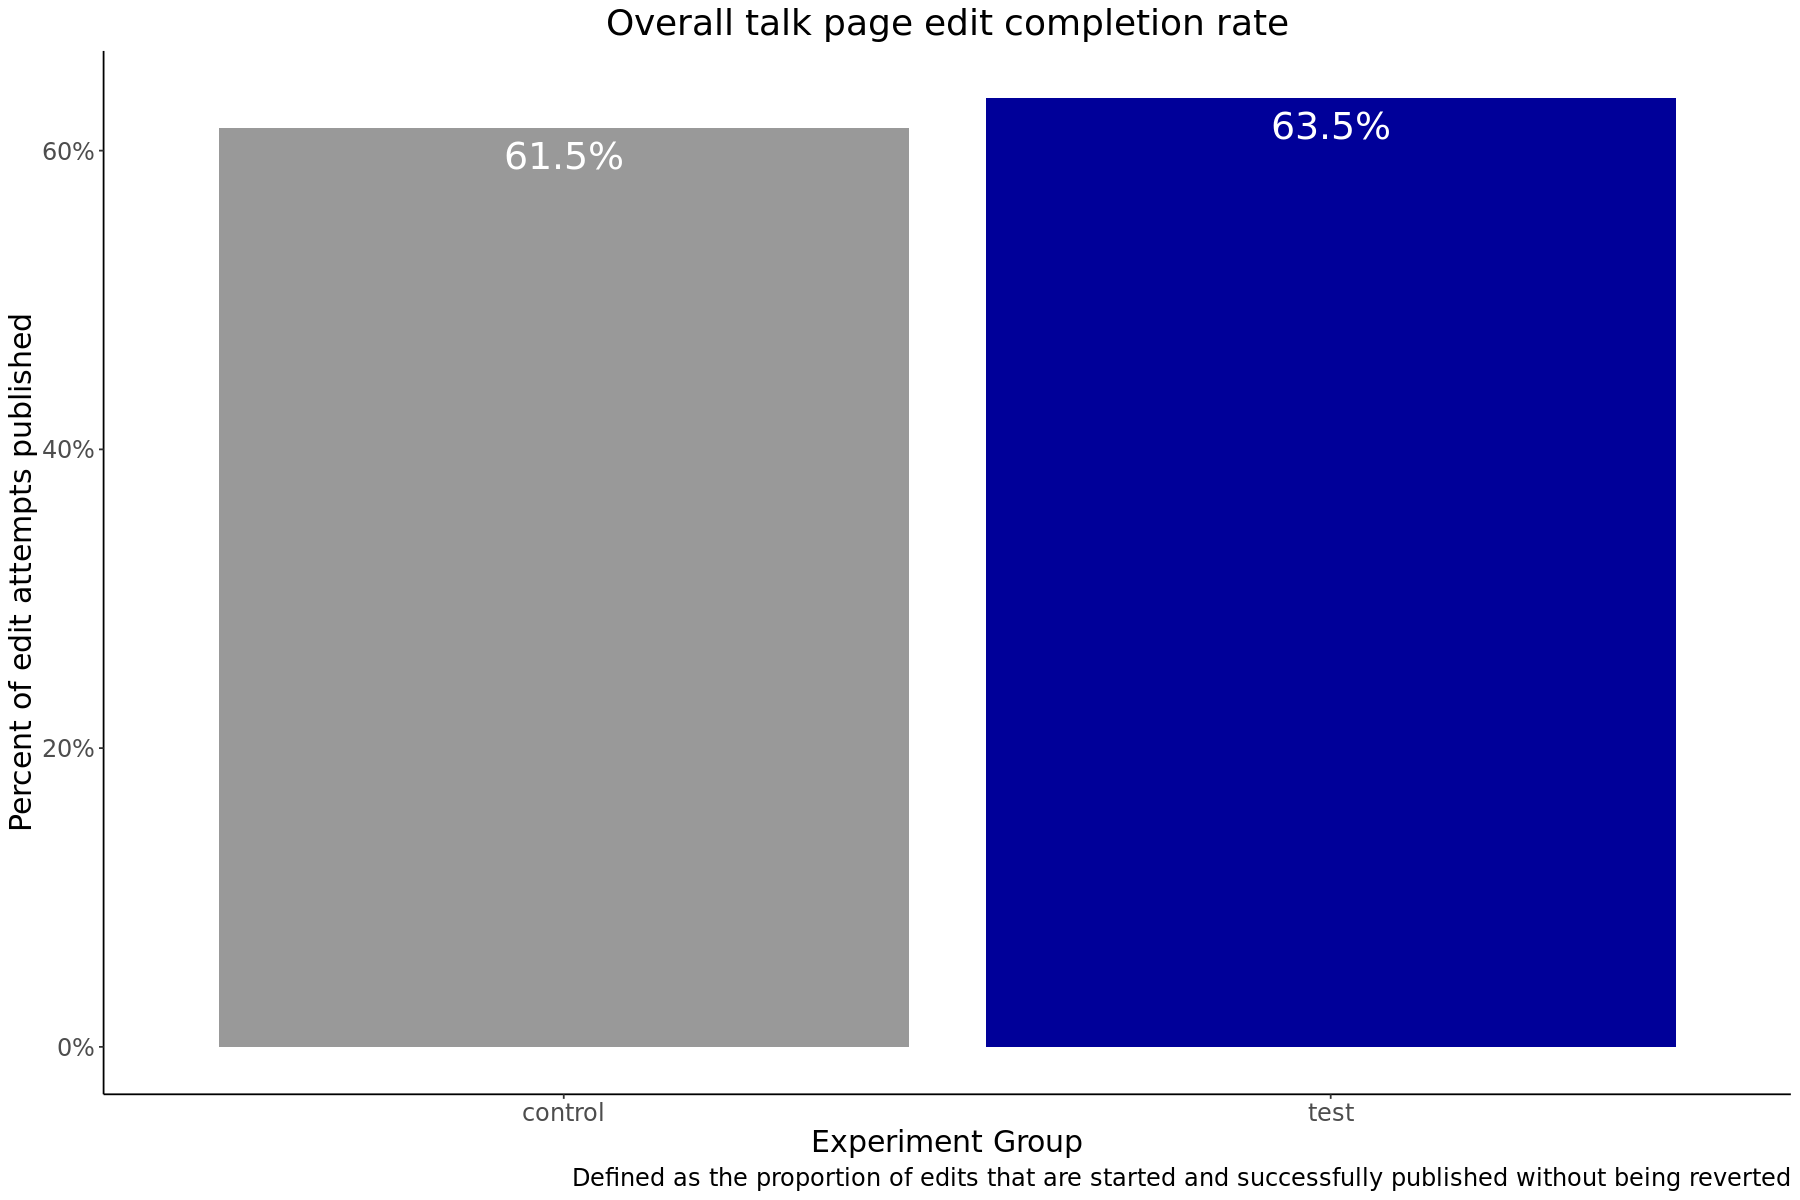

In [156]:

p <- edit_completion_rate_overall  %>%
        ggplot(aes(x = experiment_group, y= completion_rate, fill = experiment_group)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(completion_rate * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment Group",
              y = "Percent of edit attempts published",
             title = "Overall talk page edit completion rate",
             caption = "Defined as the proportion of edits that are started and successfully published without being reverted") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
          guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/edit_completion_rate_overall.png", p, width = 10, height = 8, units = "in", dpi = 300) 

People shown the set of usability improvements were slightly more likely to complete an edit that they started. Overall, there was a 3.3% increase (+2 percentage points) in edit completion rate across all participating Wikipedias.

## By Editing Interface

In [157]:
edit_completion_rate_interface <- edit_completion_data %>%
    group_by (experiment_group, integration) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete'& edit_reverted == 0]),
              completion_rate = round(n_saves/n_attempts,3))


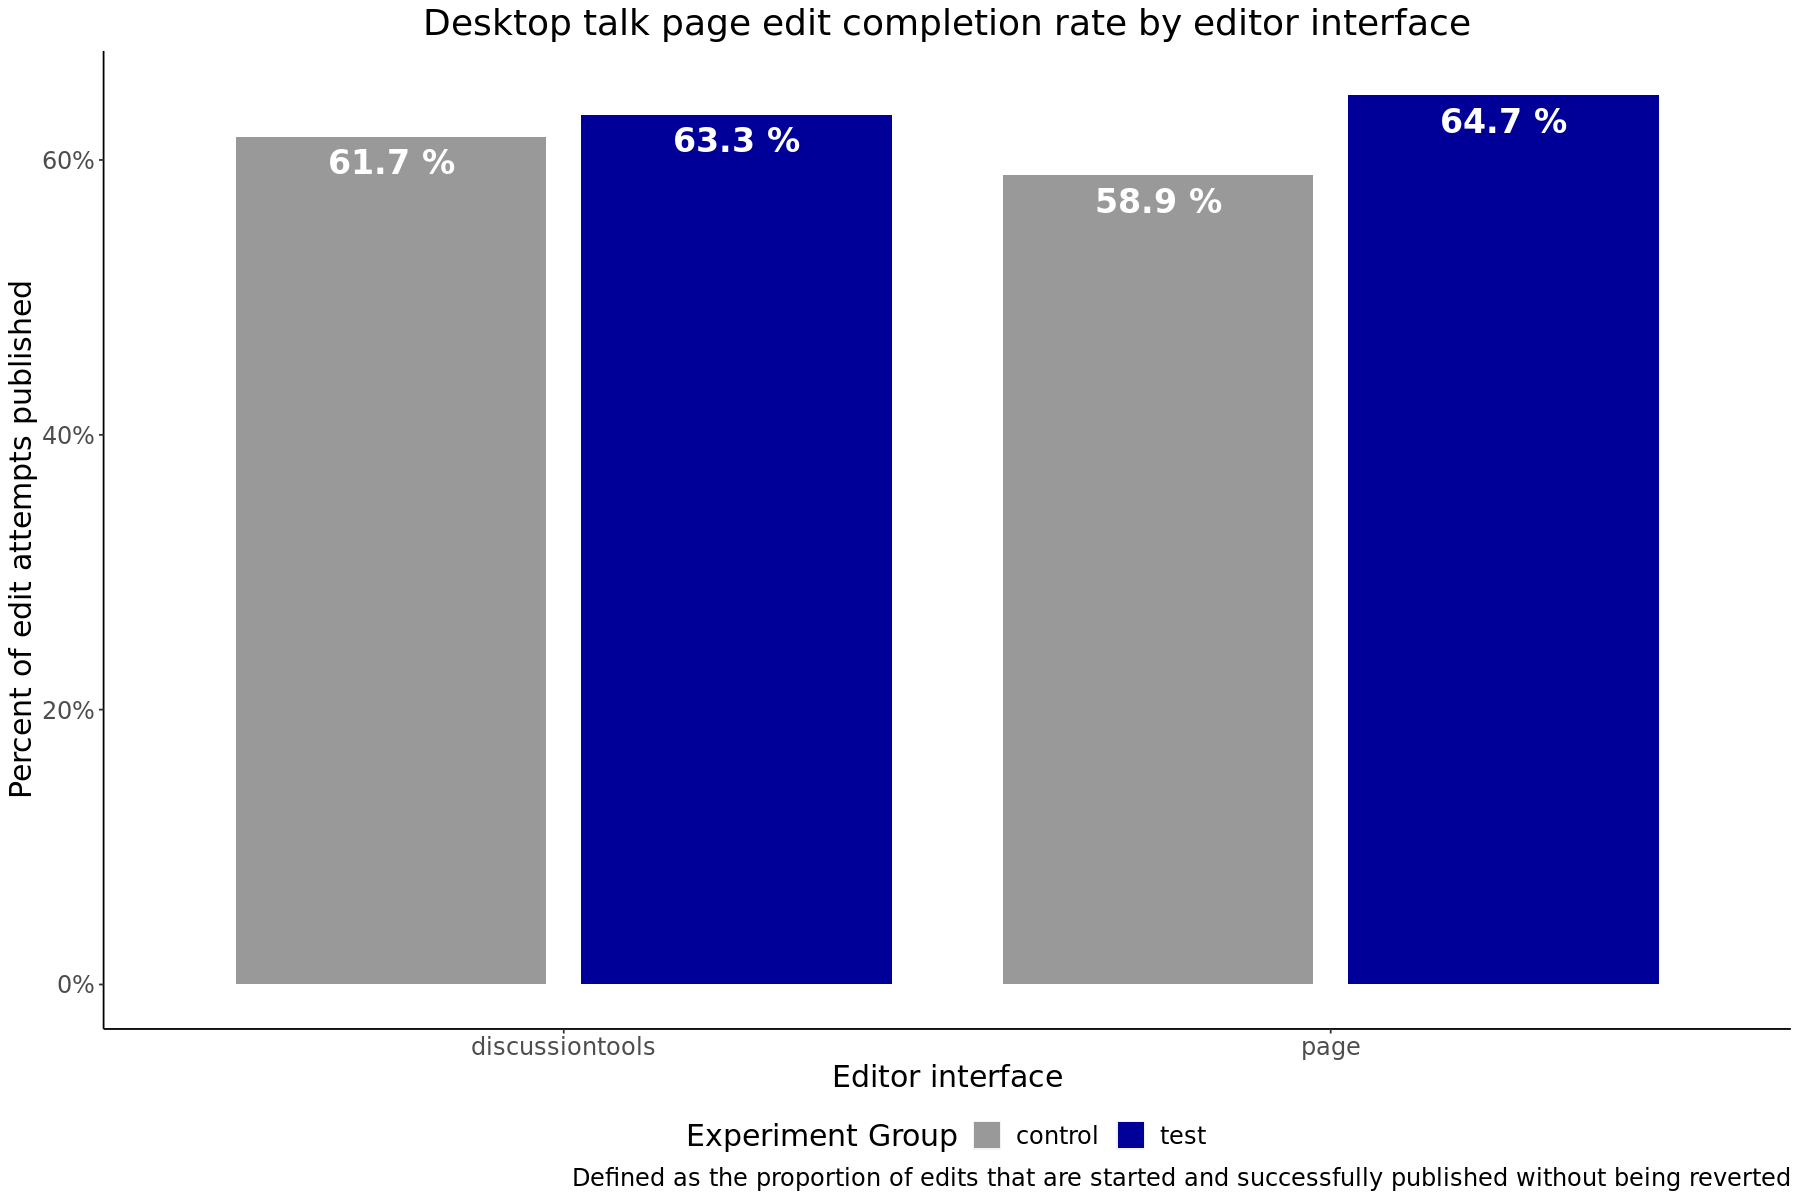

In [161]:

p <- edit_completion_rate_interface  %>%
        ggplot(aes(x = integration, y= completion_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor interface",
              y = "Percent of edit attempts published",
             title = "Desktop talk page edit completion rate by editor interface",
             caption = "Defined as the proportion of edits that are started and successfully published without being reverted") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
      guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/edit_completion_rate_interfac.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## By Experience Level

In [162]:
edit_completion_rate_exp <- edit_completion_data %>%
    group_by (experiment_group, initial_edit_count) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete' & edit_reverted == 0]),
              completion_rate = round(n_saves/n_attempts,3))


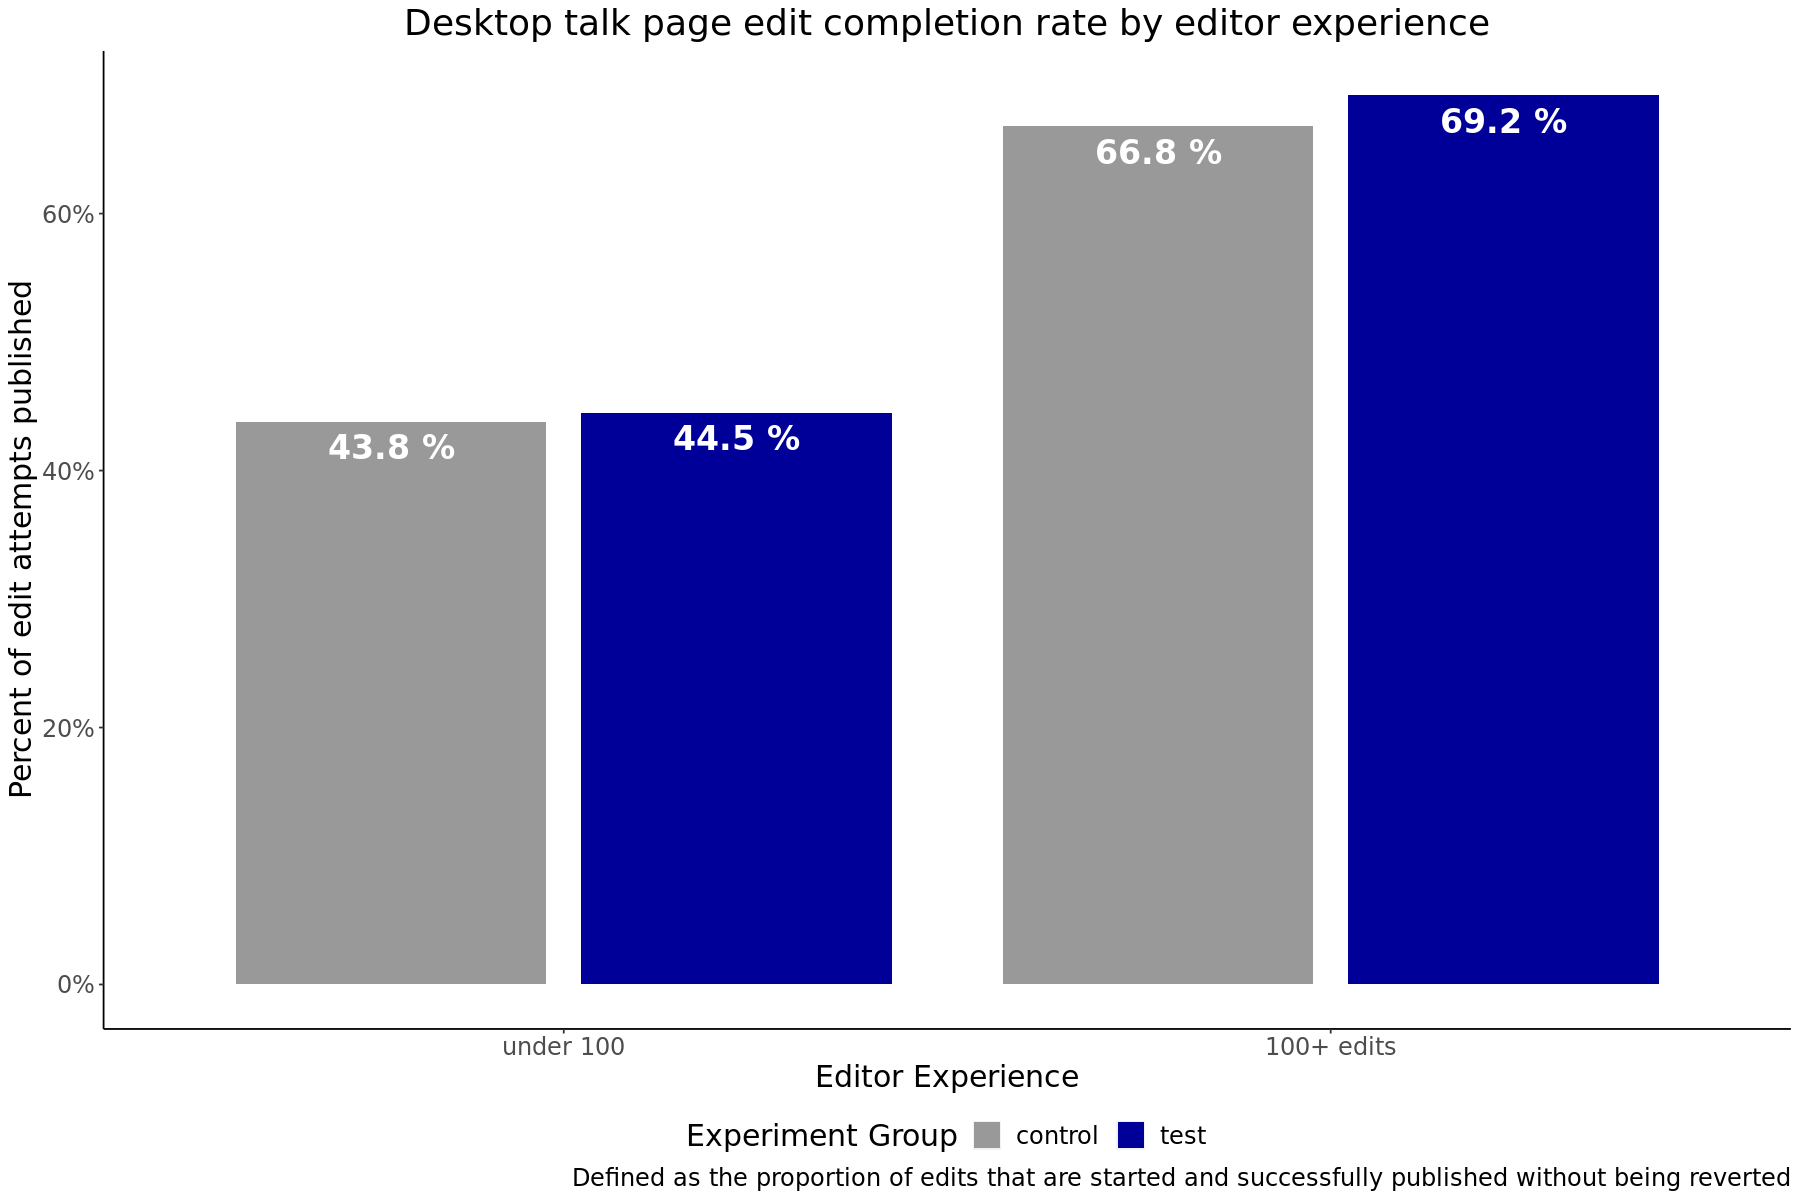

In [163]:
# Plot search sessions initiated by pre and post deployment

p <- edit_completion_rate_exp  %>%
        ggplot(aes(x = initial_edit_count, y= completion_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor Experience",
              y = "Percent of edit attempts published",
             title = "Desktop talk page edit completion rate by editor experience",
             caption = "Defined as the proportion of edits that are started and successfully published without being reverted") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
        guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/edit_completion_rate_exp.png", p, width = 10, height = 8, units = "in", dpi = 300) 

We observed increases in edit completion rate on talk pages for both Junior and Senior contributors. Increases are shown below:
Junior Contributors: 1.6% increase (43.8%→44.5%)
Senior contributors: 3.6% increase (66.8%→69.2%)

## By Desktop Skin

In [164]:
edit_completion_rate_skin <- edit_completion_data %>%
    group_by (experiment_group, skin) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete' & edit_reverted == 0]),
              completion_rate = round(n_saves/n_attempts,3))


In [165]:

p <- edit_completion_rate_skin   %>%
        ggplot(aes(x = skin, y= completion_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Desktop skin",
              y = "Percent of edits attempts published",
             title = "Desktop talk page edit completion rate by desktop skin type",
             caption = "Defined as the proportion of edits that are started and successfully published without being reverted") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
        guides(fill=guide_legend(title="Experiment Group")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/edit_completion_rate_skin.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## By Wiki

In [ ]:
edit_completion_rate_wiki <- edit_completion_data %>%
    group_by (experiment_group, wiki) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete'& edit_reverted == 0]),
              completion_rate = round(n_saves/n_attempts, 3)) %>%
    arrange(wiki)


In [168]:

p <- edit_completion_rate_wiki    %>%
        filter(wiki != 'Thai Wikipedia')  %>%
        ggplot(aes(x = experiment_group, y= completion_rate, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(completion_rate * 100,"%"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki) +
        labs (x = "Desktop skin",
              y = "Percent of edit attempts published",
             title = "Desktop talk page edit completin rate by participating wiki",
          caption = "Thai Wikipedia did not have any sufficient published edits during the reviewed timeframe to include in analysis") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/edit_completion_rate_wiki .png", p, width = 10, height = 8, units = "in", dpi = 300) 

# Block rate

Defined as the proportion of people who publish talk page edits and are subsequently blocked. This was the final KPI identified for this analysis.

Data comes from the [mediawiki_user_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_user_history) table. All block events were identified in the data by `caused_by_event_type = "alterblocks"`. The data includes any Contributors that were blocked after posting a comment; however, we do not know if they were blocked specifically due to the comment posted. 


In [26]:
block_user_data <-
  read.csv(
    file = 'Data/block_data_ab.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all block data 

In [27]:
#reformat and clean data
block_user_data$date <- as.Date(block_user_data$date, format = "%Y-%m-%d")

#clarfiy wiki names
block_user_data <- block_user_data %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
      wiki == 'kowiki' ~ "Korean Wikipedia", 
      wiki == 'viwiki' ~ "Vietnamese Wikipedia",
      wiki == 'dewiki' ~ "German Wikipedia",
    )
  ) 

# group user edit count 
block_user_data <- block_user_data %>%
 mutate(
    initial_edit_count = case_when(
       initial_edit_count < 100  ~ "under 100",
      initial_edit_count  >= 100 ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
block_user_data$initial_edit_count <-
  factor(block_user_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))

## Overall

In [28]:
block_rate_overall <- block_user_data %>%
    group_by(experiment_group) %>%
  summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = round(n_blocks/n_users,3))


In [175]:

p <- block_rate_overall %>%
        ggplot(aes(x = experiment_group, y= block_rate, fill = experiment_group)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(block_rate * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment Group",
              y = "Percent of users blocked",
             title = "Overall block rate of talk page editors",
            caption = "Defined as the proportion of people who publish talk page edits and are subsequently blocked.") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/block_rate_overall.png", p, width = 10, height = 8, units = "in", dpi = 300) 

Overall, there were 11 total editors (0.6% of talk page editors) blocked in the control group after making a talk page edit vs 10 total users (0.5% of talk page editors) in the test group.

## By Experience Level

In [176]:
block_rate_byexp <- block_user_data %>%
    group_by(experiment_group, initial_edit_count) %>%
  summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = round(n_blocks/n_users, 3))


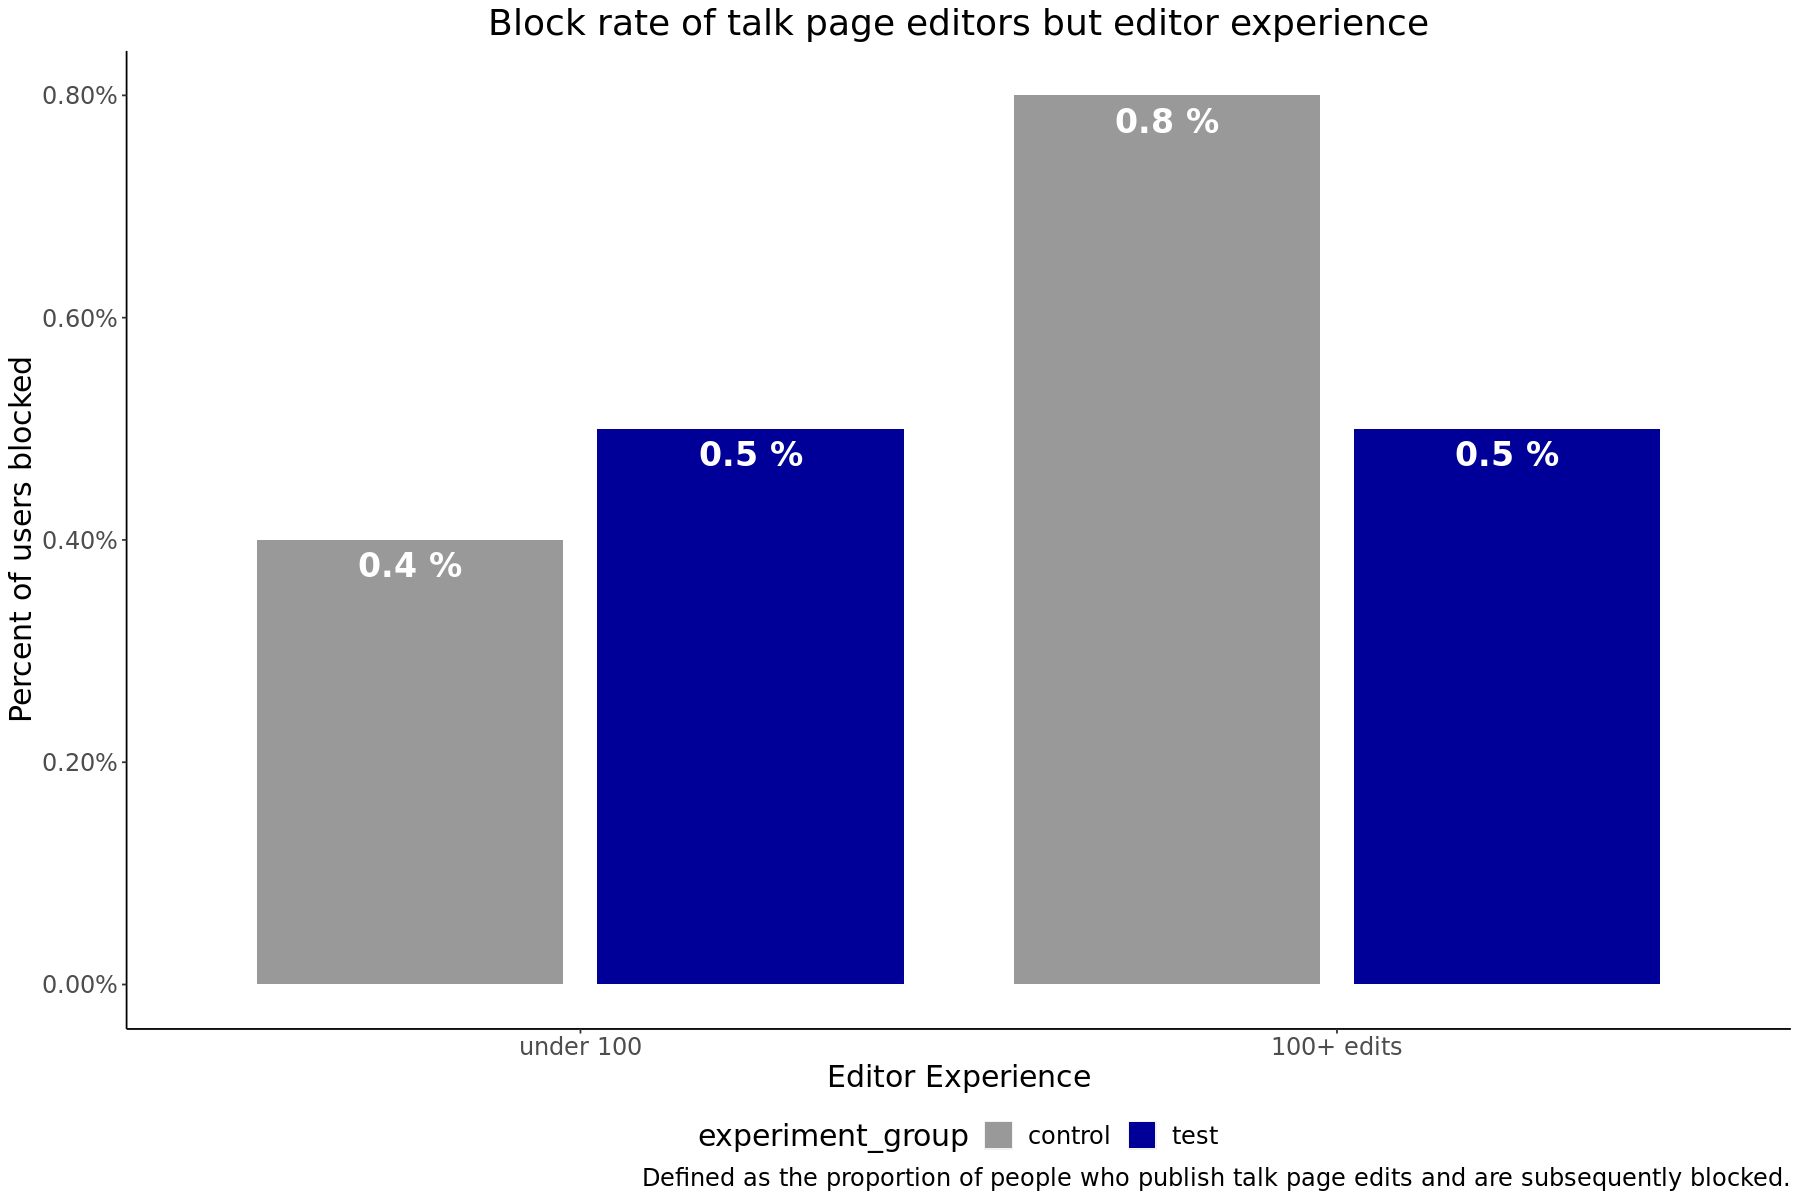

In [177]:
p <- block_rate_byexp   %>%
        ggplot(aes(x = initial_edit_count, y= block_rate, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(block_rate * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor Experience",
              y = "Percent of users blocked",
             title = "Block rate of talk page editors but editor experience",
            caption = "Defined as the proportion of people who publish talk page edits and are subsequently blocked.") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/block_rate_byexp.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## By Desktop Skin

In [ ]:
block_rate_byskin <- block_user_data %>%
    group_by(experiment_group, skin) %>%
  summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = round(n_blocks/n_users,3))


## By Wiki

In [ ]:
block_rate_bywiki <- block_user_data %>%
    group_by(wiki, experiment_group) %>%
  summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = round(n_blocks/n_users,3))  %>%
    arrange(wiki)


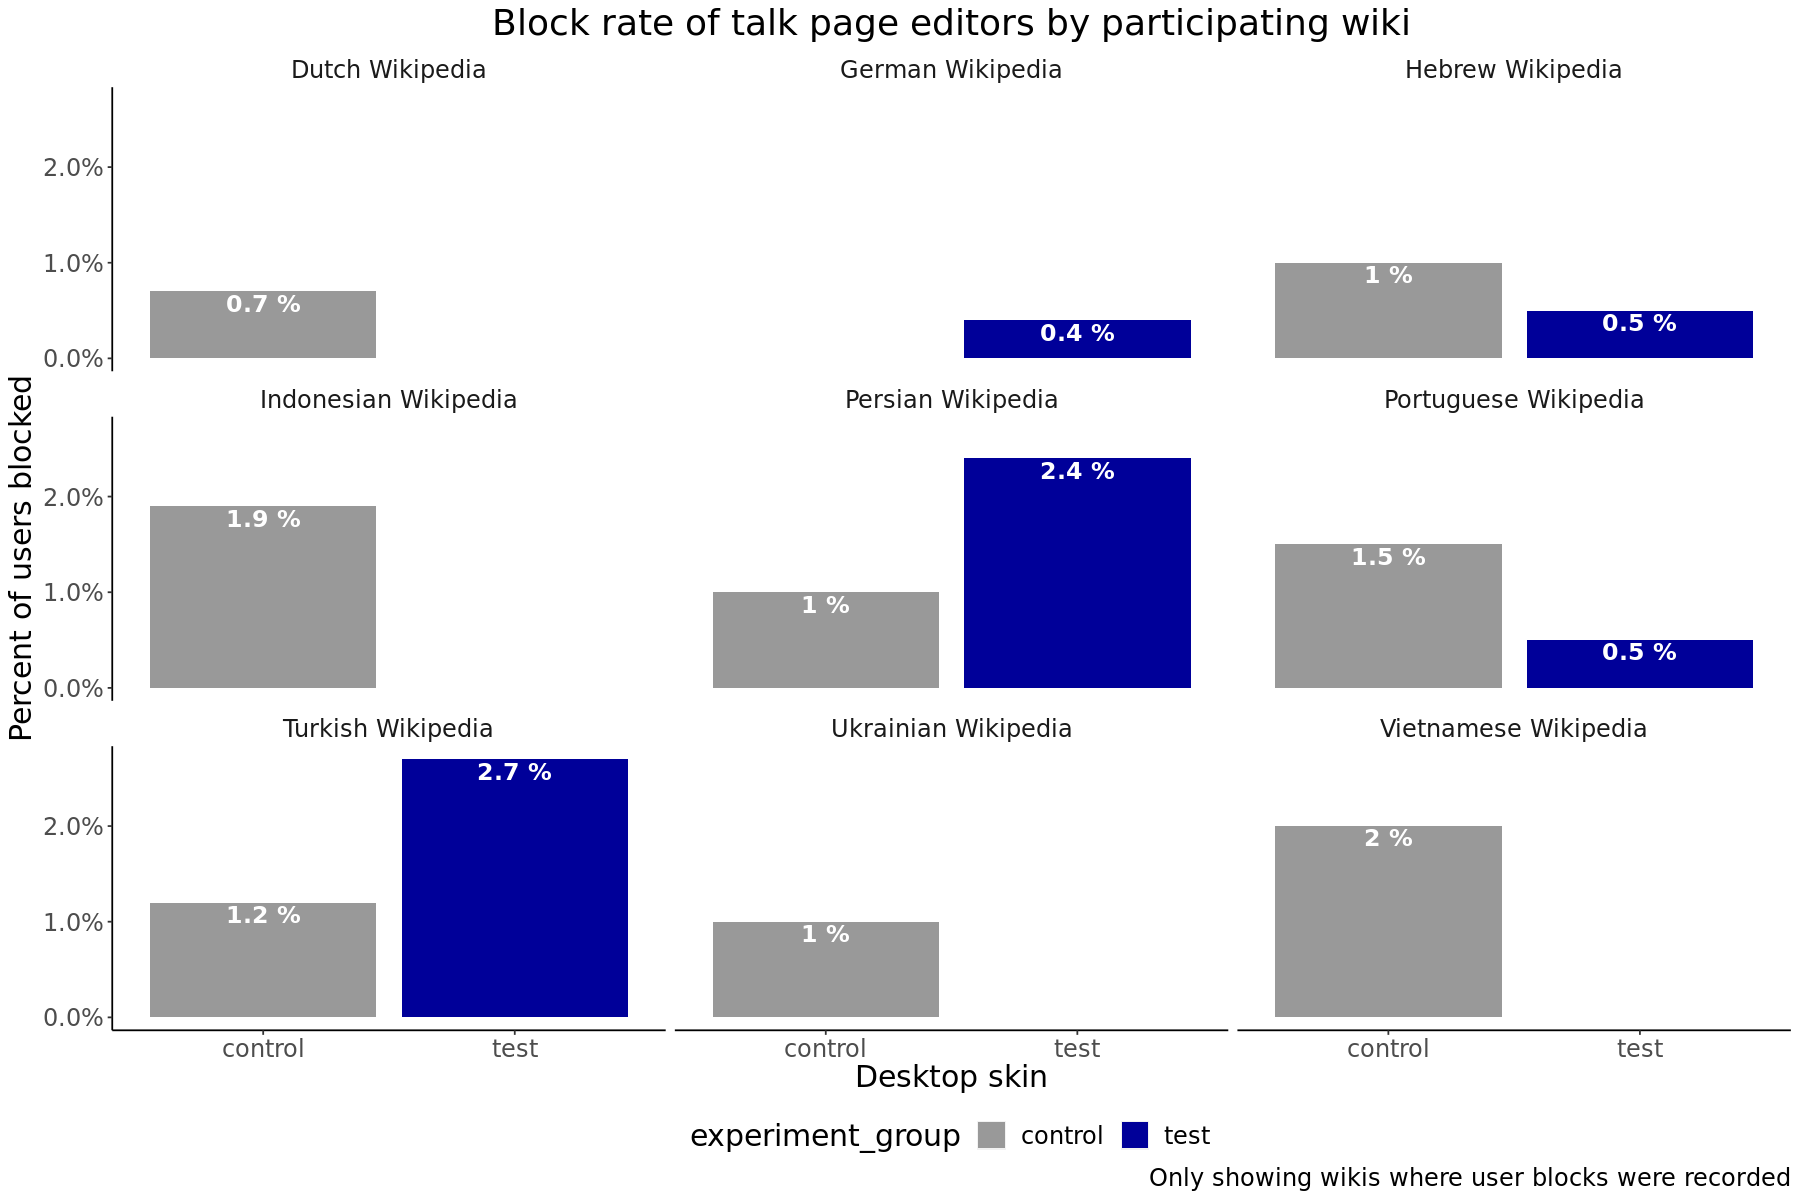

In [180]:

p <- block_rate_bywiki   %>%
        filter(wiki %in% c('Vietnamese Wikipedia', 'Ukrainian Wikipedia', 'Turkish Wikipedia', 'Portuguese Wikipedia',
                          'Persian Wikipedia', 'Indonesian Wikipedia', 'Hebrew Wikipedia', 'German Wikipedia', 'Dutch Wikipedia'))  %>%
        ggplot(aes(x = experiment_group, y= block_rate, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(block_rate * 100,"%"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki) +
        labs (x = "Desktop skin",
              y = "Percent of users blocked",
             title = "Block rate of talk page editors by participating wiki",
          caption = "Only showing wikis where user blocks were recorded") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/block_rate_bywiki.png", p, width = 10, height = 8, units = "in", dpi = 300) 

# Average time duration from Junior Contributor viewing a desktop talk page to engagement

Defined as: The average time duration from when a Junior Contributor views a talk page to when they engage on the page in some way (for example, click an affordance to comment or start a conversation). Note: For the purpose of this analysis, I am defining engagement as any attempt to start either a reply or new topic on a talk page.

Hypothesis: Junior Contributors will intuitively understand talk pages, across namespaces, as tools they can use to communicate with other volunteers because they will recognize other people using these pages to talk and identify the affordances they can use to do the same.

Notes: To get an accurate time estimate of the user's actual time to view and click, I used client dt as there can be variation in the server timestamp . However, this excluded edits completed with wikitext so this analysis is limited to just clicks to the reply tool or new topic tool on talk pages.


In [29]:
edit_engagement_data <-
  read.csv(
    file = 'Data/edit_engagement_data_ab.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) 

In [30]:
# Reformat dates

edit_engagement_data$view_time <- as.POSIXct(edit_engagement_data$view_time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
edit_engagement_data$engage_time <- as.POSIXct(edit_engagement_data$engage_time, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [31]:
#reformat and clean data

#clarfiy wiki names
edit_engagement_data <- edit_engagement_data %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
      wiki == 'kowiki' ~ "Korean Wikipedia", 
      wiki == 'viwiki' ~ "Vietnamese Wikipedia",
      wiki == 'dewiki' ~ "German Wikipedia",
    )
  ) 

# group user edit count 
edit_engagement_data <- edit_engagement_data %>%
 mutate(
    initial_edit_count = case_when(
       initial_edit_count %in% c('1-4 edits', '0 edits', '5-99 edits')  ~ "under 100",
      initial_edit_count %in% c('100-999 edits', '1000+ edits')  ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
edit_engagement_data$initial_edit_count <-
  factor(edit_engagement_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))

In [32]:
# take average time for each session
# Editing session can have multiple page tokens
time_to_engage_data <- edit_engagement_data %>%
    filter(edit_attempt == 1,
           workflow != 'page',
          initial_edit_count == "under 100") %>% # only review JC edit attempt events. Remove page as wikitext init events are only logged server side
    group_by(edit_attempt_id, experiment_group, skin, wiki, workflow) %>%
    summarise(view_time = mean(view_time),
              engage_time = mean(engage_time),
            duration = as.numeric(difftime(engage_time, view_time, units = "secs")))  


## Overall Time to Engage


In [33]:
control_q <- round(quantile(time_to_engage_data$duration[time_to_engage_data$experiment_group == 'control'], probs = c(0.25, 0.5, 0.75), 3))


### Control Group

In [257]:
# Create histogram for control group


time_to_engage_histogram_control <- time_to_engage_data %>%
    filter(experiment_group == 'control') %>%
    ggplot(aes(x=duration)) +  #round to nearest minute
    geom_histogram(color = 'black', fill = "#999999") +
    geom_vline(aes(xintercept = control_q[1], color = '25th Percentile'), linetype = 'dashed', size = 1.5) +
     geom_vline(aes(xintercept = control_q[2], color = '50th Percentile'), linetype = 'dashed', size = 1.5) +
    geom_vline(aes(xintercept = control_q[3], color = '75th Percentile'), linetype = 'dashed', size = 1.5) +
      geom_label(aes(x = control_q[1], y =350, label = paste0(control_q[1], " sec"))) +
      geom_label(aes(x = control_q[2], y = 300, label = paste0(control_q[2], " secs"))) +
      geom_label(aes(x = control_q[3], y = 350, label = paste0(control_q[3], " secs"))) +
    facet_wrap(~ experiment_group) +
      scale_x_log10(breaks=c(1,60,3600),labels=c("1sec","1min","1hour")) +
    scale_y_continuous()+
    labs (title = "Time to talk page engagement by Junior Contributors in the control group",
          y = "Number of instances",
         x= "Time to engagement in seconds (log scale)")   + 
    scale_color_manual(name='Percentiles',
                     breaks=c('25th Percentile', '50th Percentile', '75th Percentile'),
                     values=c("25th Percentile" = "darkblue", "50th Percentile" = "darkmagenta", "75th Percentile" = "darkred")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 

time_to_engage_histogram_control

ggsave("Figures/time_to_engage_histogram_control.png",time_to_engage_histogram, width = 16, height = 11, units = "in", dpi = 300)




Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 25 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



### Test Group

In [34]:
#quantiles for test group
test_q <- round(quantile(time_to_engage_data$duration[time_to_engage_data$experiment_group == 'test'], probs = c(0.25, 0.5, 0.75), 3))


Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 19 rows containing non-finite values (stat_bin).”


ERROR: Error in grid.draw(plot): object 'time_to_engage_histogram' not found


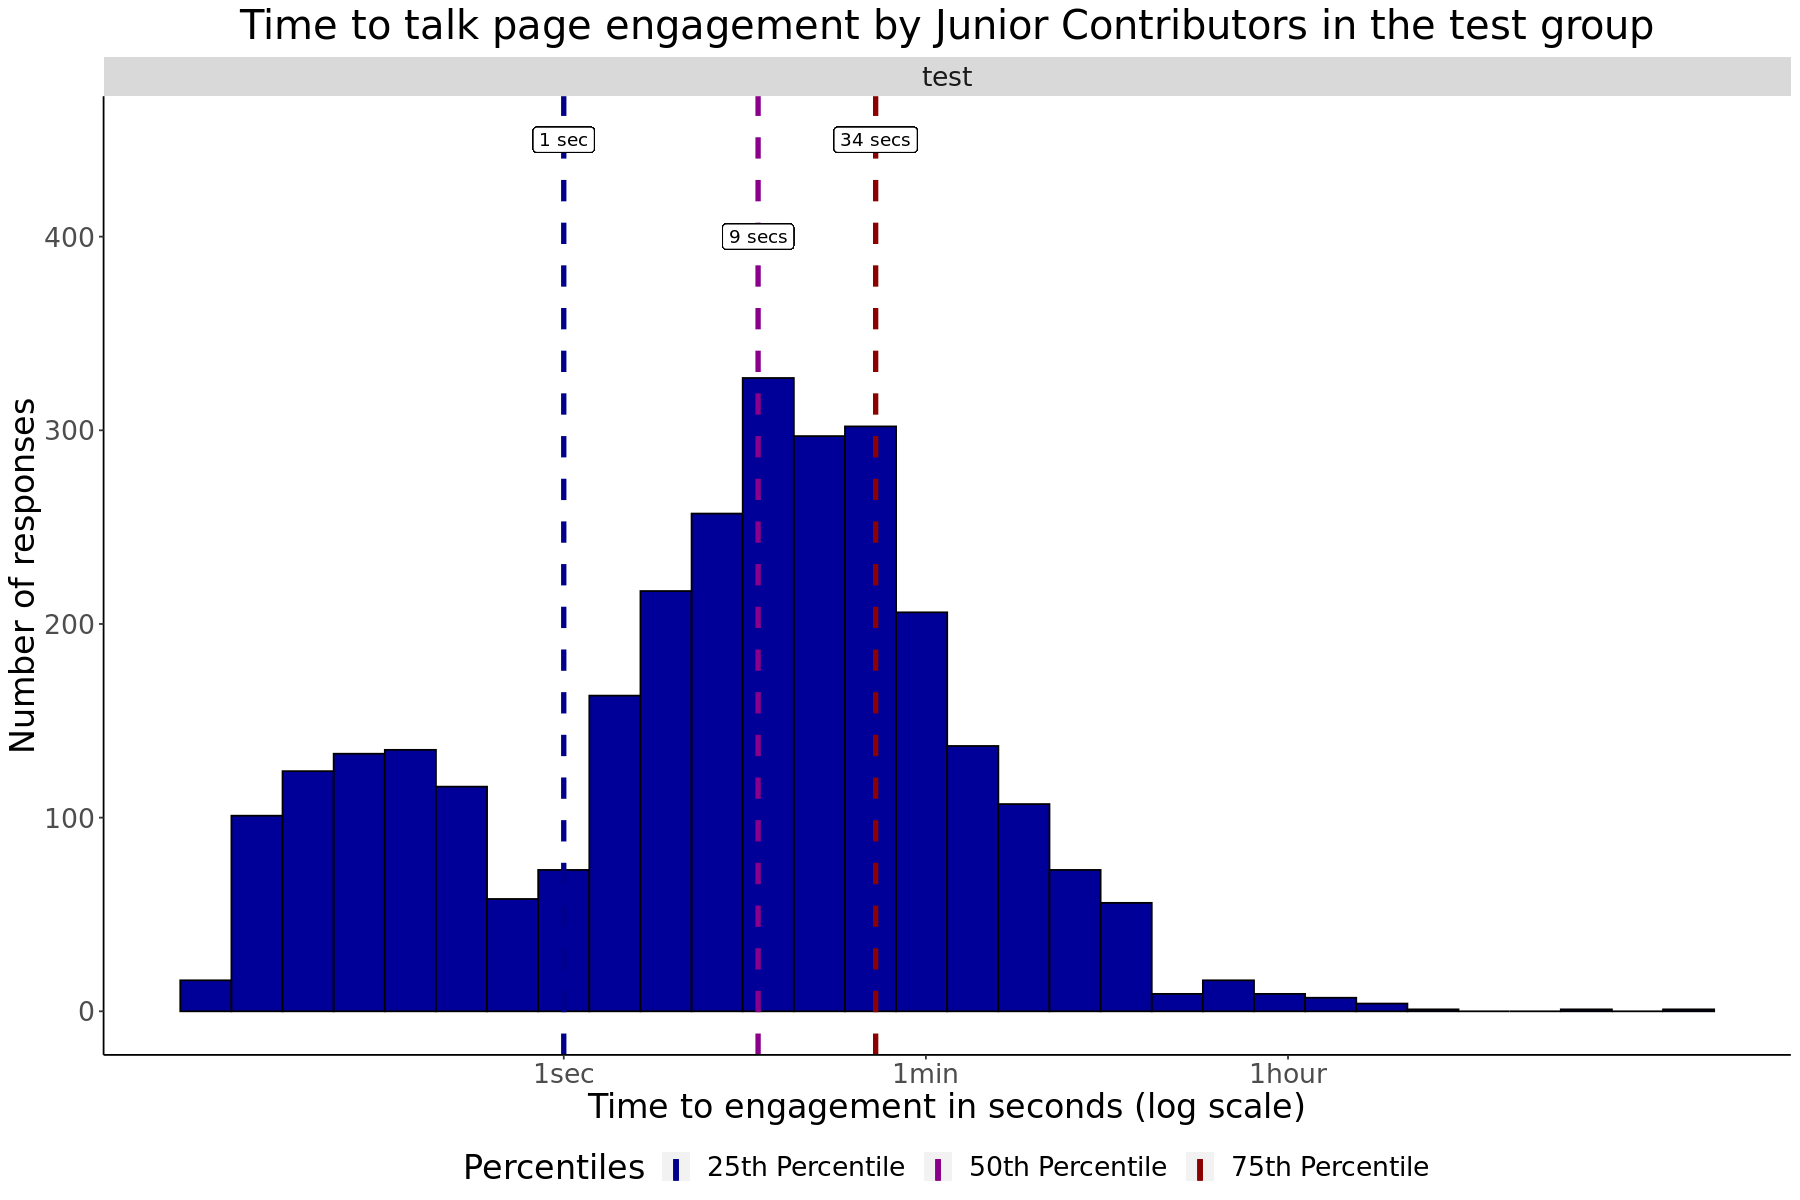

In [36]:
# Create histogram for control group

time_to_engage_histogram_test <- time_to_engage_data %>%
    filter(experiment_group == 'test') %>%
    ggplot(aes(x=duration)) +  #round to nearest minute
    geom_histogram(color = 'black', fill = "#000099") +
    geom_vline(aes(xintercept = test_q[1], color = '25th Percentile'), linetype = 'dashed', size = 1.5) +
     geom_vline(aes(xintercept = test_q[2], color = '50th Percentile'), linetype = 'dashed', size = 1.5) +
    geom_vline(aes(xintercept = test_q[3], color = '75th Percentile'), linetype = 'dashed', size = 1.5) +
      geom_label(aes(x = test_q[1], y =450, label = paste0(test_q[1], " sec"))) +
      geom_label(aes(x = test_q[2], y = 400, label = paste0(test_q[2], " secs"))) +
      geom_label(aes(x = test_q[3], y = 450, label = paste0(test_q[3], " secs"))) +
    facet_wrap(~ experiment_group) +
      scale_x_log10(breaks=c(1,60,3600),labels=c("1sec","1min","1hour")) +
    scale_y_continuous()+
    labs (title = "Time to talk page engagement by Junior Contributors in the test group",
          y = "Number of responses",
         x= "Time to engagement in seconds (log scale)")   + 
    scale_color_manual(name='Percentiles',
                     breaks=c('25th Percentile', '50th Percentile', '75th Percentile'),
                     values=c("25th Percentile" = "darkblue", "50th Percentile" = "darkmagenta", "75th Percentile" = "darkred")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 

time_to_engage_histogram_test

ggsave("Figures/time_to_engage_histogram_test.png",time_to_engage_histogram, width = 16, height = 11, units = "in", dpi = 300)

We observed similar distributions in time to engagement for both test groups indicating no significant changes in the overall time to engagement. Overall, there was just a 2-second increase in the median time to engage from 7 to 9 seconds.

## Overall

In [38]:

time_to_engage_overall <- time_to_engage_data %>%
    group_by(experiment_group) %>%
    summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
            duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs")) %>% 
    pivot_wider(names_from = quantile, values_from =  duration)

time_to_engage_overall

experiment_group 25%    50%    75%    
1 control          1 secs 7 secs 28 secs
2 test             1 secs 9 secs 34 secs

## By Editing Interface

In [39]:
time_to_engage_interface <- time_to_engage_data %>%
    group_by(experiment_group, workflow) %>%
    summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
             duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs"))  %>% 
    pivot_wider(names_from = quantile, values_from =  duration)
   

time_to_engage_interface

experiment_group workflow       25%    50%     75%    
1 control          new_topic_tool 0 secs 2 secs  11 secs
2 control          reply_tool     7 secs 21 secs 61 secs
3 test             new_topic_tool 0 secs 2 secs  10 secs
4 test             reply_tool     8 secs 22 secs 66 secs

The median time to engage is similar for both test groups when broken down by editing workflow type: adding a new topic or replying. There is a longer median time to engage for users adding comment vs users starting a new topic.

The median time to save for the new topic tool was 2 seconds both groups, while the median time to add a comment using the reply tool increased by just one second from 21 to 22 seconds.

## By Desktop Skin

In [40]:

time_to_engage_skin <-  time_to_engage_data %>%
    group_by(experiment_group, skin)  %>%
    summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
             duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs"))  %>% 
    pivot_wider(names_from = quantile, values_from =  duration)
   

time_to_engage_skin

experiment_group skin        25%    50%     75%    
1 control          vector      0 secs 4 secs  24 secs
2 control          vector-2022 3 secs 9 secs  33 secs
3 test             vector      0 secs 7 secs  32 secs
4 test             vector-2022 2 secs 10 secs 36 secs

## By Wiki

In [207]:

time_to_engage_wiki <- time_to_engage_data %>%
    group_by(experiment_group, wiki) %>%
    summarise(median_time_to_engage = round(median(duration), 0),
             mean_time_to_engage = round(mean(duration), 0), .groups = 'drop'
             )  %>%
    arrange(wiki)
   


In [194]:

p <- time_to_engage_wiki  %>%
       # filter(wiki %in% c('Vietnamese Wikipedia', 'Ukrainian Wikipedia', 'Turkish Wikipedia', 'Portuguese Wikipedia',
                  #      'Persian Wikipedia', 'Indonesian Wikipedia', 'Hebrew Wikipedia', 'German Wikipedia', 'Dutch Wikipedia'))  %>%
        ggplot(aes(x = experiment_group, y= median_time_to_engage, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(median_time_to_engage," secs"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki) +
        labs (x = "Experiment Group",
              y = "median time (secs)",
             title = "Median time from talk page view to click for for Junior Contributors",
          caption = "Only showing wikis where user blocks were recorded") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/time_to_engage_wiki.png", p, width = 10, height = 8, units = "in", dpi = 300) 

# Proportion of Junior Contributors that visit a talk page and engage with the page

We also reviewed the proprotion of Junior Contributors that visit a talk page and engage with the page in some way. For the purpose of this analyis, this is identified as any atttempt to edit. This analysis also helps evaulate the identified guardrail for this analysis: Number of page views without any clicks.

Note: 
* The `desktopwebuiactionstracking` schema does not track distinct users. As a result, we reviewed percent of talk page visits by Junior contributors that include a click to start an edit.
* The experiment group of the user is only tracked in `editattemptstep` for users that start an edit. For this purpose of this analysis, we assumed there was a 50/50 split of overall talk page views during the AB test. We comparted the total number of edit attempts for each group when estimating proportion of talk page views was not feasible. 


## Overall

In [209]:

pct_engagement_overall <- edit_engagement_data %>%
    filter(initial_edit_count != '100+ edits') %>% # only Juniors
    mutate(total_views = n()* 0.50) %>%
    filter(experiment_group != "") %>%
    group_by(experiment_group) %>%
    summarise(n_attempts = sum(edit_attempt > 0),
              total_views,
             engagement_rate = round(n_attempts/total_views, 3)) %>%
    distinct()


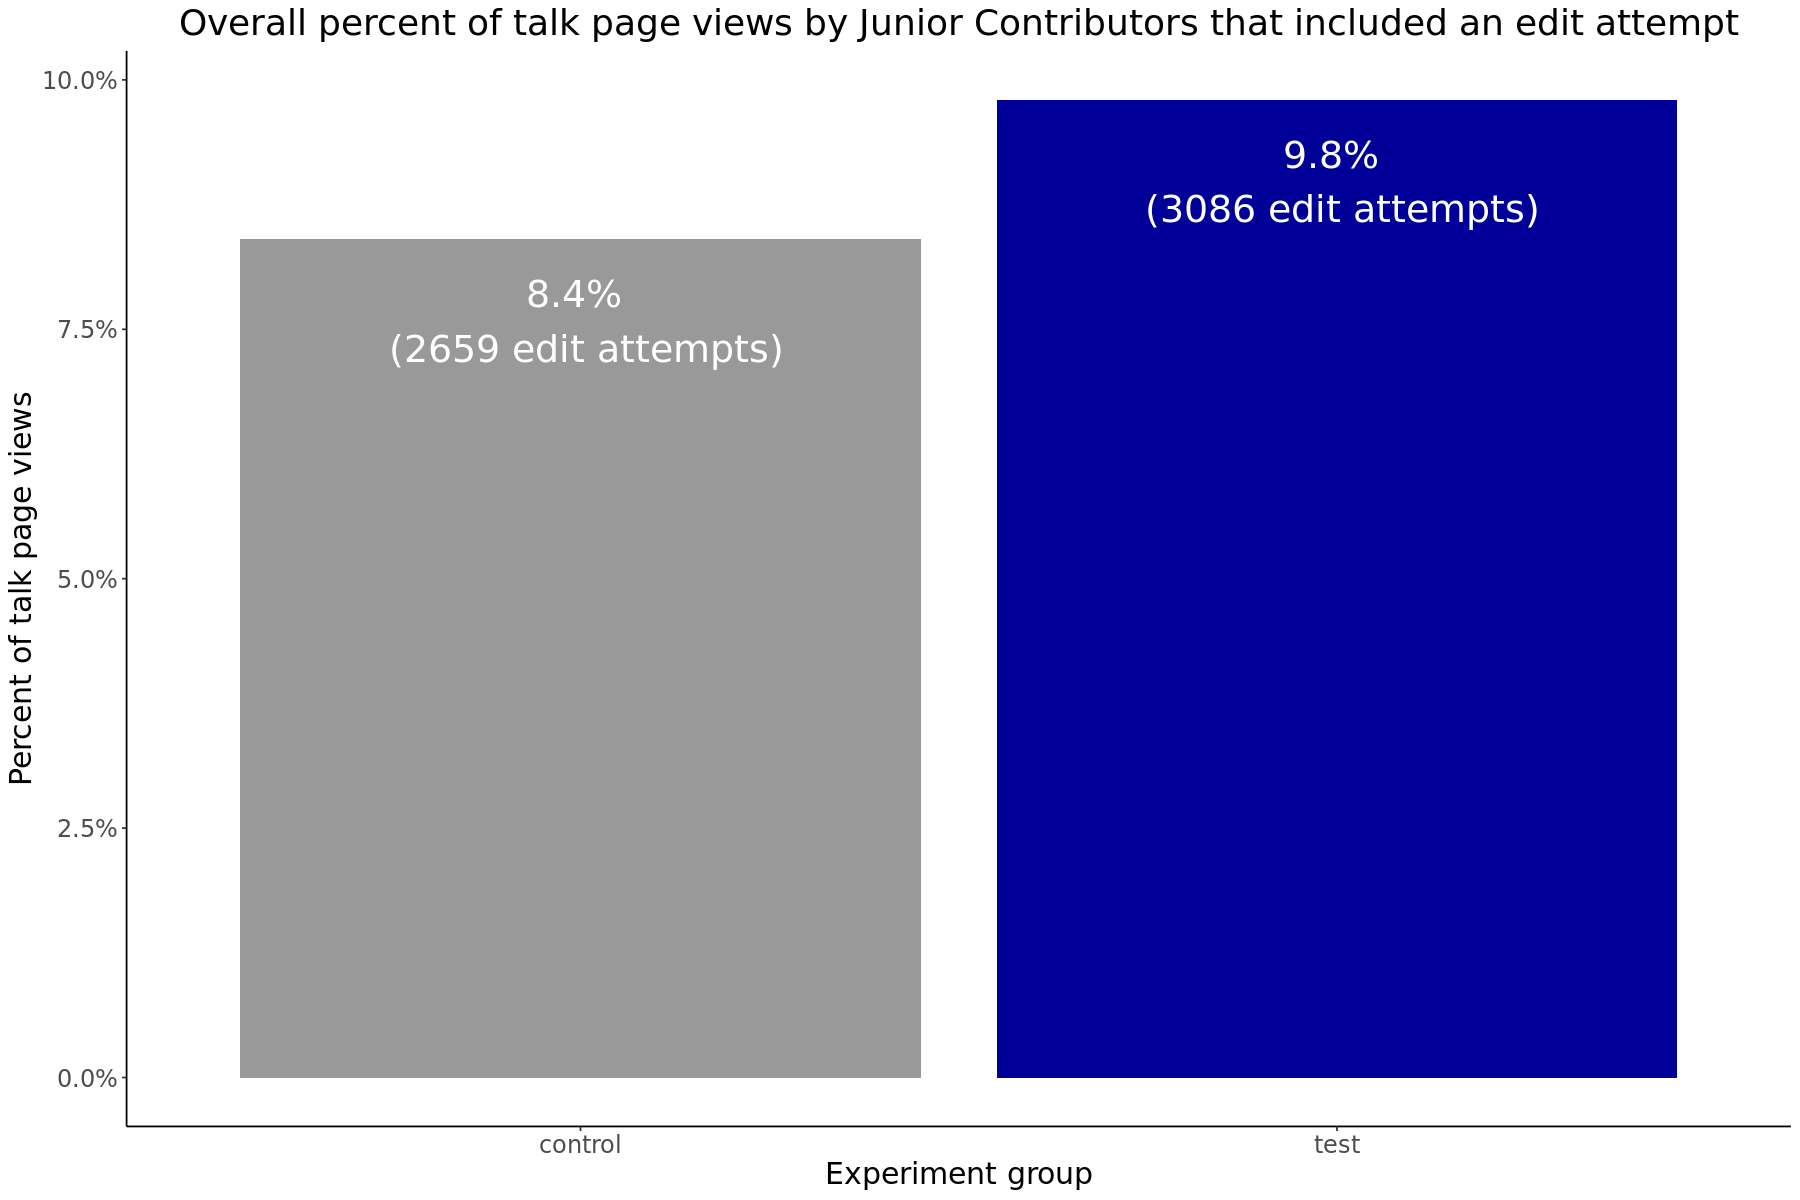

In [210]:

p <- pct_engagement_overall   %>%
        ggplot(aes(x = experiment_group, y= engagement_rate, fill = experiment_group)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(engagement_rate * 100,'%', ' \n (', n_attempts, ' edit attempts)')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment group",
              y = "Percent of talk page views",
             title = "Overall percent of talk page views by Junior Contributors that included an edit attempt") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/pct_engagement_overall.png", p, width = 10, height = 8, units = "in", dpi = 300) 

Overall, more talk page views by Junior Contributors in the test group included at least one attempt to engage with the page. We observed a 16.7% (1.4 percentage point increase) increase in talk page engagement by Junior Contributors.


## By Desktop Skin

In [214]:
pct_engagement_skin <- edit_engagement_data %>%
    filter(initial_edit_count != '100+ edits') %>% # only Juniors
    group_by(skin) %>%
    mutate(total_views = n() * 0.50) %>%
    filter(experiment_group != "") %>%
    group_by(experiment_group, skin) %>%
    summarise(n_attempts = sum(edit_attempt > 0)) %>%
    distinct()

pct_engagement_skin

experiment_group skin        n_attempts
1 control          vector      1255      
2 control          vector-2022 1404      
3 test             vector      1617      
4 test             vector-2022 1469

In [220]:

p <- pct_engagement_skin  %>%
        ggplot(aes(x = skin, y= n_attempts, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste0(n_attempts, ' edit', ' \n attempts')), fontface=2, vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Desktop skin",
              y = "Number of edit attempts",
             title = "Number of edit attempts by Junior Contributors that viewed a talk page \n by desktop skin type") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/pct_engagement_skin.png", p, width = 10, height = 8, units = "in", dpi = 300) 

We observed increases for users of both desktop skin types, with a slightly higher increase observed for users of Vector 2022.

## By Wiki

In [51]:
# set threshold for high level editing reporting
threshold <- 50

pct_engagement_wiki <- edit_engagement_data %>%
    filter(initial_edit_count != '100+ edits') %>% # only Juniors
    group_by(wiki) %>%
    mutate(total_views = n() * 0.50) %>%
    filter(experiment_group != "") %>%
    group_by(experiment_group, wiki) %>%
    summarise(n_attempts = sum(edit_attempt > 0)) %>%
    mutate(n_attempts = ifelse(n_attempts < 50,
                            glue("<{threshold}"),
                            n_attempts)) %>%
    distinct()  %>%
    arrange(wiki)


pct_engagement_wiki

experiment_group wiki                  n_attempts
1  control          Azerbaijani Wikipedia <50       
2  test             Azerbaijani Wikipedia 68        
3  control          Bengali Wikipedia     54        
4  test             Bengali Wikipedia     <50       
5  control          Dutch Wikipedia       164       
6  test             Dutch Wikipedia       163       
7  control          German Wikipedia      943       
8  test             German Wikipedia      1142      
9  control          Hebrew Wikipedia      144       
10 test             Hebrew Wikipedia      249       
11 control          Hindi Wikipedia       50        
12 test             Hindi Wikipedia       104       
13 control          Indonesian Wikipedia  121       
14 test             Indonesian Wikipedia  153       
15 control          Korean Wikipedia      <50       
16 test             Korean Wikipedia      <50       
17 control          Persian Wikipedia     238       
18 test             Persian Wikipedia     266       
19 control          Portuguese Wikipedia  429       
20 test             Portuguese Wikipedia  435       
21 control          Romanian Wikipedia    <50       
22 test             Romanian Wikipedia    56        
23 control          Thai Wikipedia        59        
24 test             Thai Wikipedia        <50       
25 control          Turkish Wikipedia     127       
26 test             Turkish Wikipedia     125       
27 control          Ukrainian Wikipedia   109       
28 test             Ukrainian Wikipedia   142       
29 control          Vietnamese Wikipedia  122       
30 test             Vietnamese Wikipedia  70

Results vary per wiki. We observed increases across all wikis except for 5: Azerbaijani, Dutch, Hebrew, Persian, and Ukrainian Wikipedias.

# Proportion of Junior Contributors who click an affordance on a talk page and successfully publish an edit

Unlike the edit completion rate analysis in the prior section, this metric looks at the proportion of unique editors that clicked on an editing affordance on a desktop talk page and saved at least 1 edit.For this analyis, edits that were reverted within 48 hours were removed. 

## Overall

In [55]:
user_completes_overall <- edit_completion_data %>%
    filter(initial_edit_count == 'under 100')  %>%
    group_by(experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 'Complete'& edit_reverted == 0]),
             pct_completed = round(n_users_published/n_users, 3))
    

In [349]:

p <- user_completes_overall   %>%
        ggplot(aes(x = experiment_group, y= pct_completed, fill = experiment_group)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste0(pct_completed * 100,'%')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment group",
              y = "Percent of junior contributors",
             title = "Overall percent of Junior Contributors that completed a talk page edit") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/user_completes_overall.png", p, width = 10, height = 8, units = "in", dpi = 300) 

In [ ]:
There was no significant change in the overall proportion of Junior Contributors that started and completed an edit across all participating Wikipedias.

## By Editor Interface

In [350]:
user_completes_byeditor <- edit_completion_data %>%
    filter(initial_edit_count == 'under 100')  %>%
    group_by(experiment_group, integration) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 'Complete' & edit_reverted == 0]),
             pct_completed = round(n_users_published/n_users, 3))
    

In [351]:

p <- user_completes_byeditor  %>%
        ggplot(aes(x = integration, y= pct_completed, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor interface",
              y = "Percent of junior contributors",
             title = "Percent of junior contributors that published a talk page edit by editor interface") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/user_completes_byeditor.png", p, width = 10, height = 8, units = "in", dpi = 300)

## By Desktop Skin

In [352]:
user_completes_byskin <- edit_completion_data %>%
    filter(initial_edit_count == 'under 100')  %>%
    group_by(experiment_group, skin) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 'Complete' & edit_reverted == 0]),
             pct_completed = round(n_users_published/n_users, 3))
    
              

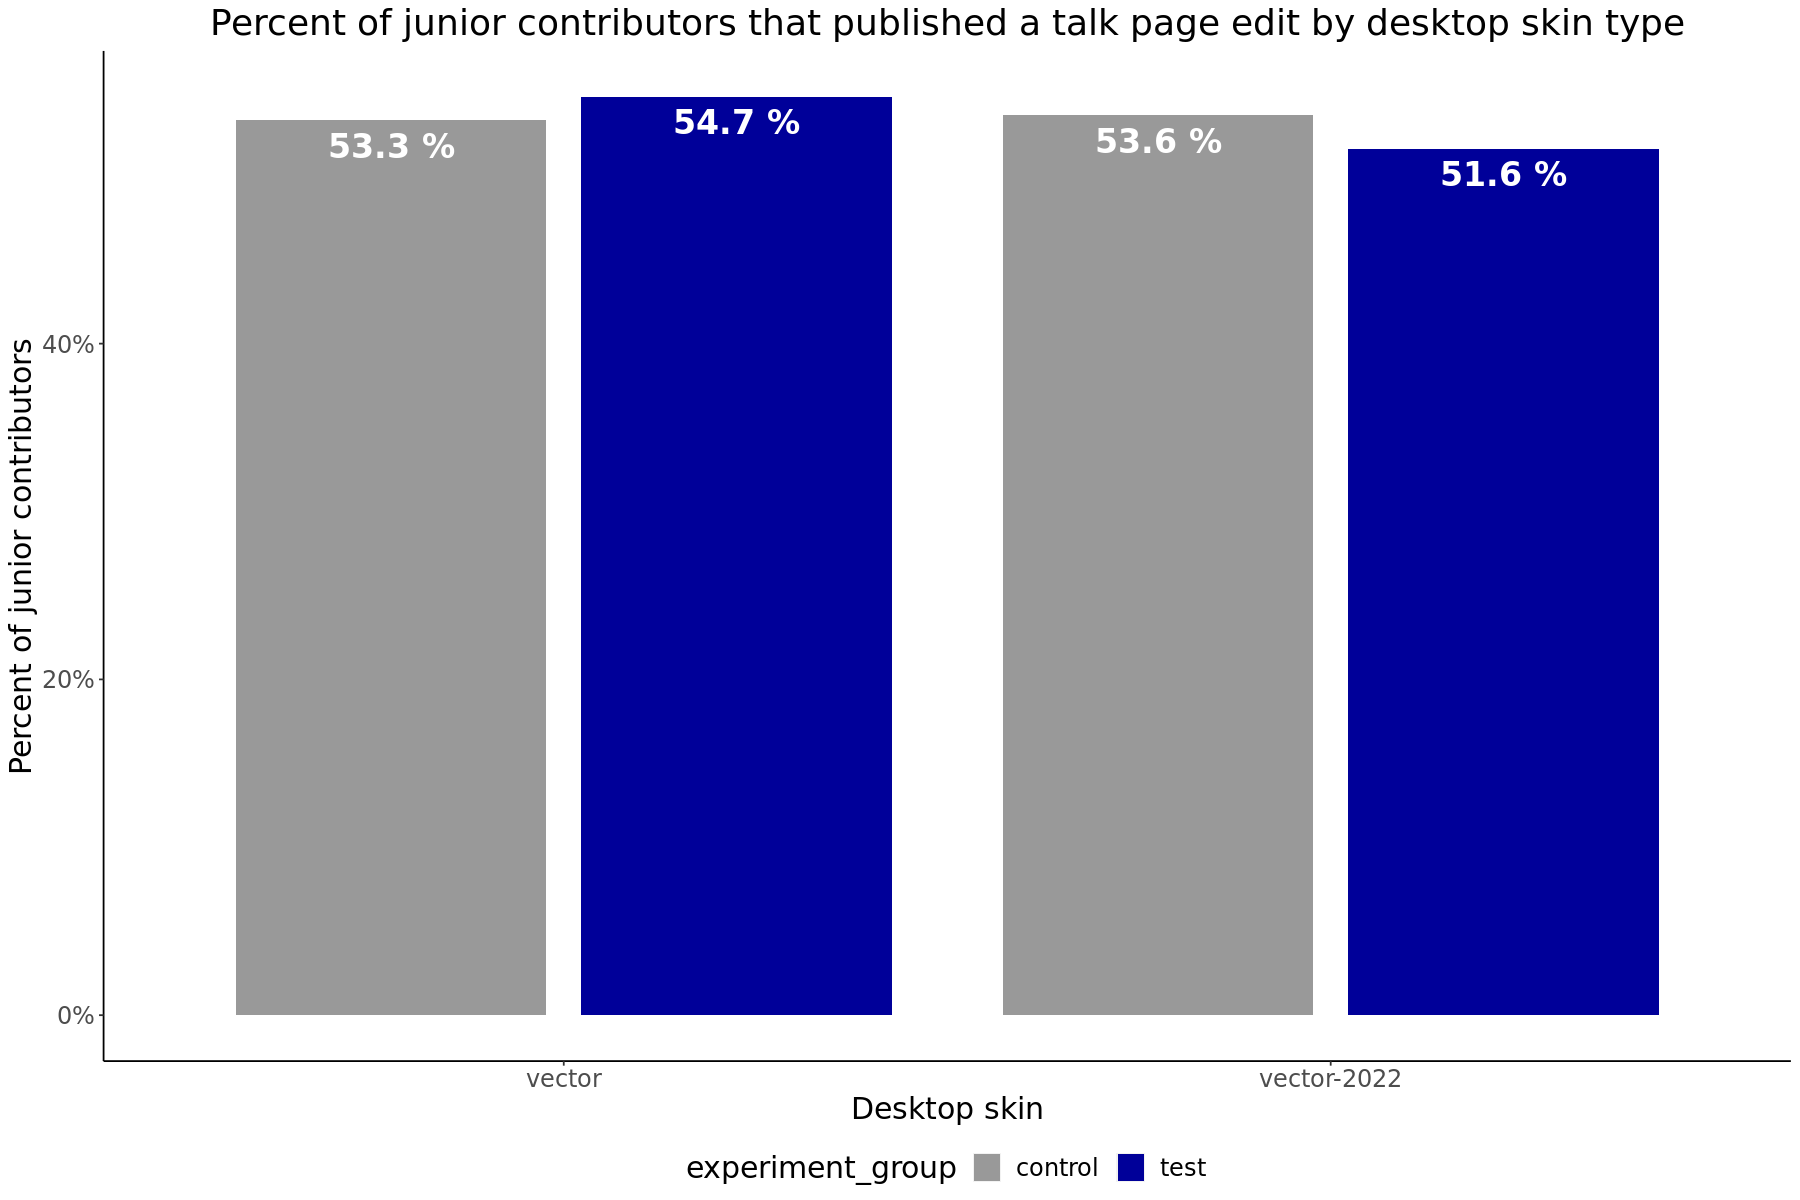

In [353]:

p <- user_completes_byskin   %>%
        ggplot(aes(x = skin, y= pct_completed, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste(pct_completed * 100, "%"), fontface=2), vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Desktop skin",
              y = "Percent of junior contributors",
             title = "Percent of junior contributors that published a talk page edit by desktop skin type") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/user_completes_byskin.png", p, width = 10, height = 8, units = "in", dpi = 300) 

## By User Edit Count

In [355]:
user_completes_byexp<- edit_completion_data %>%
    group_by(experiment_group, initial_edit_count) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 'Complete' & edit_reverted == 0]),
             pct_completed = round(n_users_published/n_users, 3))
    
user_completes_byexp          

experiment_group initial_edit_count n_users n_users_published pct_completed
1 control          under 100          1294     691              0.534        
2 control          100+ edits         1274    1036              0.813        
3 test             under 100          1356     722              0.532        
4 test             100+ edits         1340    1084              0.809

## By Wiki

In [56]:
user_completes_bywiki<- edit_completion_data %>%
    filter(initial_edit_count == 'under 100')  %>%
    group_by(wiki, experiment_group) %>%
    summarise(n_users = n_distinct(user_id),
             n_users_published = n_distinct(user_id[edit_success == 'Complete'& edit_reverted == 0]),
             pct_completed = round(n_users_published/n_users, 3))%>%
    arrange(wiki)
    
              

In [57]:

p <- user_completes_bywiki %>%
       # filter(wiki %in% c('Vietnamese Wikipedia', 'Ukrainian Wikipedia', 'Turkish Wikipedia', 'Portuguese Wikipedia',
                        #  'Persian Wikipedia', 'Indonesian Wikipedia', 'Hebrew Wikipedia', 'German Wikipedia', 'Dutch Wikipedia'))  %>%
        ggplot(aes(x = experiment_group, y= pct_completed, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(pct_completed * 100,"%"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki) +
        labs (x = "Experiment Group",
              y = "Percent of junior contributors",
             title = "Percent of junior contributors that published a talk page edit by desktop skin type") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/user_completes_bywiki.png", p, width = 10, height = 8, units = "in", dpi = 300) 

# Proportion of Junior Contributors that visit a talk page and successfully publish at least one comment or new discussion 

Edits that were reverted within 48 hours were excluded for this analysis.

Notes: 
* The `desktopwebuiactionstracking` schema does not track distinct users. As a result, we reviewed percent of talk page visits by Junior contributors that include a click to start an edit.
* The experiment group of the user is only tracked in `editattemptstep` for users that start an edit. For this purpose of this analysis, we assumed there was a 50/50 split of overall talk page views during the AB test. We comparted the total number of edit attempts for each group when estimating proportion of talk page views was not feasible. 

In [58]:
view_to_publish_data <-
  read.csv(
    file = 'Data/view_to_publish_data_ab.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all block data 

In [59]:
#reformat and clean data

#clarfiy wiki names
view_to_publish_data <- view_to_publish_data%>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
      wiki == 'kowiki' ~ "Korean Wikipedia", 
      wiki == 'viwiki' ~ "Vietnamese Wikipedia",
      wiki == 'dewiki' ~ "German Wikipedia",
    )
  ) 

# group user edit count 
view_to_publish_data <- view_to_publish_data%>%
 mutate(
    initial_edit_count = case_when(
       initial_edit_count %in% c('1-4 edits', '0 edits', '5-99 edits')  ~ "under 100",
      initial_edit_count %in% c('100-999 edits', '1000+ edits')  ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
view_to_publish_data$initial_edit_count <-
  factor(view_to_publish_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))

## Overall

In [60]:

view_to_publish_overall <- view_to_publish_data %>%
    filter(initial_edit_count != '100+ edits') %>% # only Juniors
    mutate(total_views = n()* 0.50) %>%
    filter(experiment_group != "") %>%
    group_by(experiment_group) %>%
    summarise(n_saves = sum(edit_success > 0 & is_reverted == 0),
              total_views,
             pct_engagement = round(n_saves/total_views, 3)) %>%
    distinct()



In [61]:

p <- view_to_publish_overall  %>%
        ggplot(aes(x = experiment_group, y= pct_engagement, fill = experiment_group)) +
        geom_col(position = 'dodge') +
         geom_text(aes(label = paste0(pct_engagement * 100,'%', ' \n (', n_saves, ' edits saved)')), color = "white", vjust=1.5, size = 8) +
        labs (x = "Experiment group",
              y = "Percent of talk page views",
             title = "Overall percent of talk page views by Junior Contributors \n that included a completed a talk page edit") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous(labels = scales::percent) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "none")
      
p


ggsave("Figures/view_to_publish_overall.png", p, width = 10, height = 8, units = "in", dpi = 300) 

Junior Contributors were slightly more likely to save an edit after visiting a talk page when shown usability improvements. We observed an 19% (0.7 percentage point) in the proportion of talk page views by Junior Contributors that included a saved edit. 

## By Desktop Skin

In [238]:
view_to_publish_skin <- view_to_publish_data %>%
    filter(initial_edit_count != '100+ edits') %>% # only Juniors
    group_by(skin) %>%
    mutate(total_views = n() * 0.50) %>%
    filter(experiment_group != "") %>%
    group_by(skin, experiment_group) %>%
    summarise(n_saves = sum(edit_success > 0 & is_reverted == 0)) %>%
    distinct() 


In [239]:
p <- view_to_publish_skin  %>%
        ggplot(aes(x = skin, y= n_saves, fill = experiment_group)) +
          geom_col(position = position_dodge2(preserve = "single")) +
         geom_text(aes(label = paste0(n_saves, '\n edits saved')), fontface=2, vjust=1.5, size = 7, color = "white", position = position_dodge(0.9)) +
        labs (x = "Editor Experience",
              y = "Number of edits saved",
             title = "Number of talk page saved edits by Junior Contributors \n that vieweded a talk page by desktop skin") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/view_to_publish_skin.png", p, width = 10, height = 8, units = "in", dpi = 300) 

This was consistent for each desktop skin type.
Vector: 537 edits saved in the control group; 730 edits saved in the test group
Vector 2022: 623 edits saved in the control group; 643 edits saved in the test group

# Average time duration from Senior Contributor viewing a desktop talk page to engagement

Hypothesis: Senior Contributors will be able to more quickly and easily decide where to focus their attention when arriving on a talk page because they will be able to see, at a glance, what new comments and/or discussions have been added since they last visited.

Notes: To get an accurate time estimate of the user's actual time to view and click, I used client dt as there can be variation in the server timestamp . However, this excluded edits completed with wikitext so this analysis is limited to just clicks to the reply tool or new topic tool on talk pages.

In [63]:
# find the average time difference

time_to_engage_data_sc <- edit_engagement_data %>%
    filter(edit_attempt == 1,
           workflow != 'page',
          initial_edit_count == "100+ edits") %>% # # only review SC edit attempt events. Remove page as wikitext init events are only logged server side
    mutate(time_to_engage = difftime(engage_time, view_time)) %>%  ## add column to show response time
    group_by(edit_attempt_id, experiment_group, skin, wiki, workflow) %>%
       summarise(view_time = mean(view_time),
              engage_time = mean(engage_time),
            duration = as.numeric(difftime(engage_time, view_time, units = "secs")))  



## Overall time to engage

### Control

In [64]:
control_q_sc <- round(quantile(time_to_engage_data_sc$duration[time_to_engage_data_sc$experiment_group == 'control'], 
                            probs = c(0.25, 0.5, 0.75), 3))


Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 33 rows containing non-finite values (stat_bin).”


ERROR: Error in grid.draw(plot): object 'time_to_engage_histogram' not found


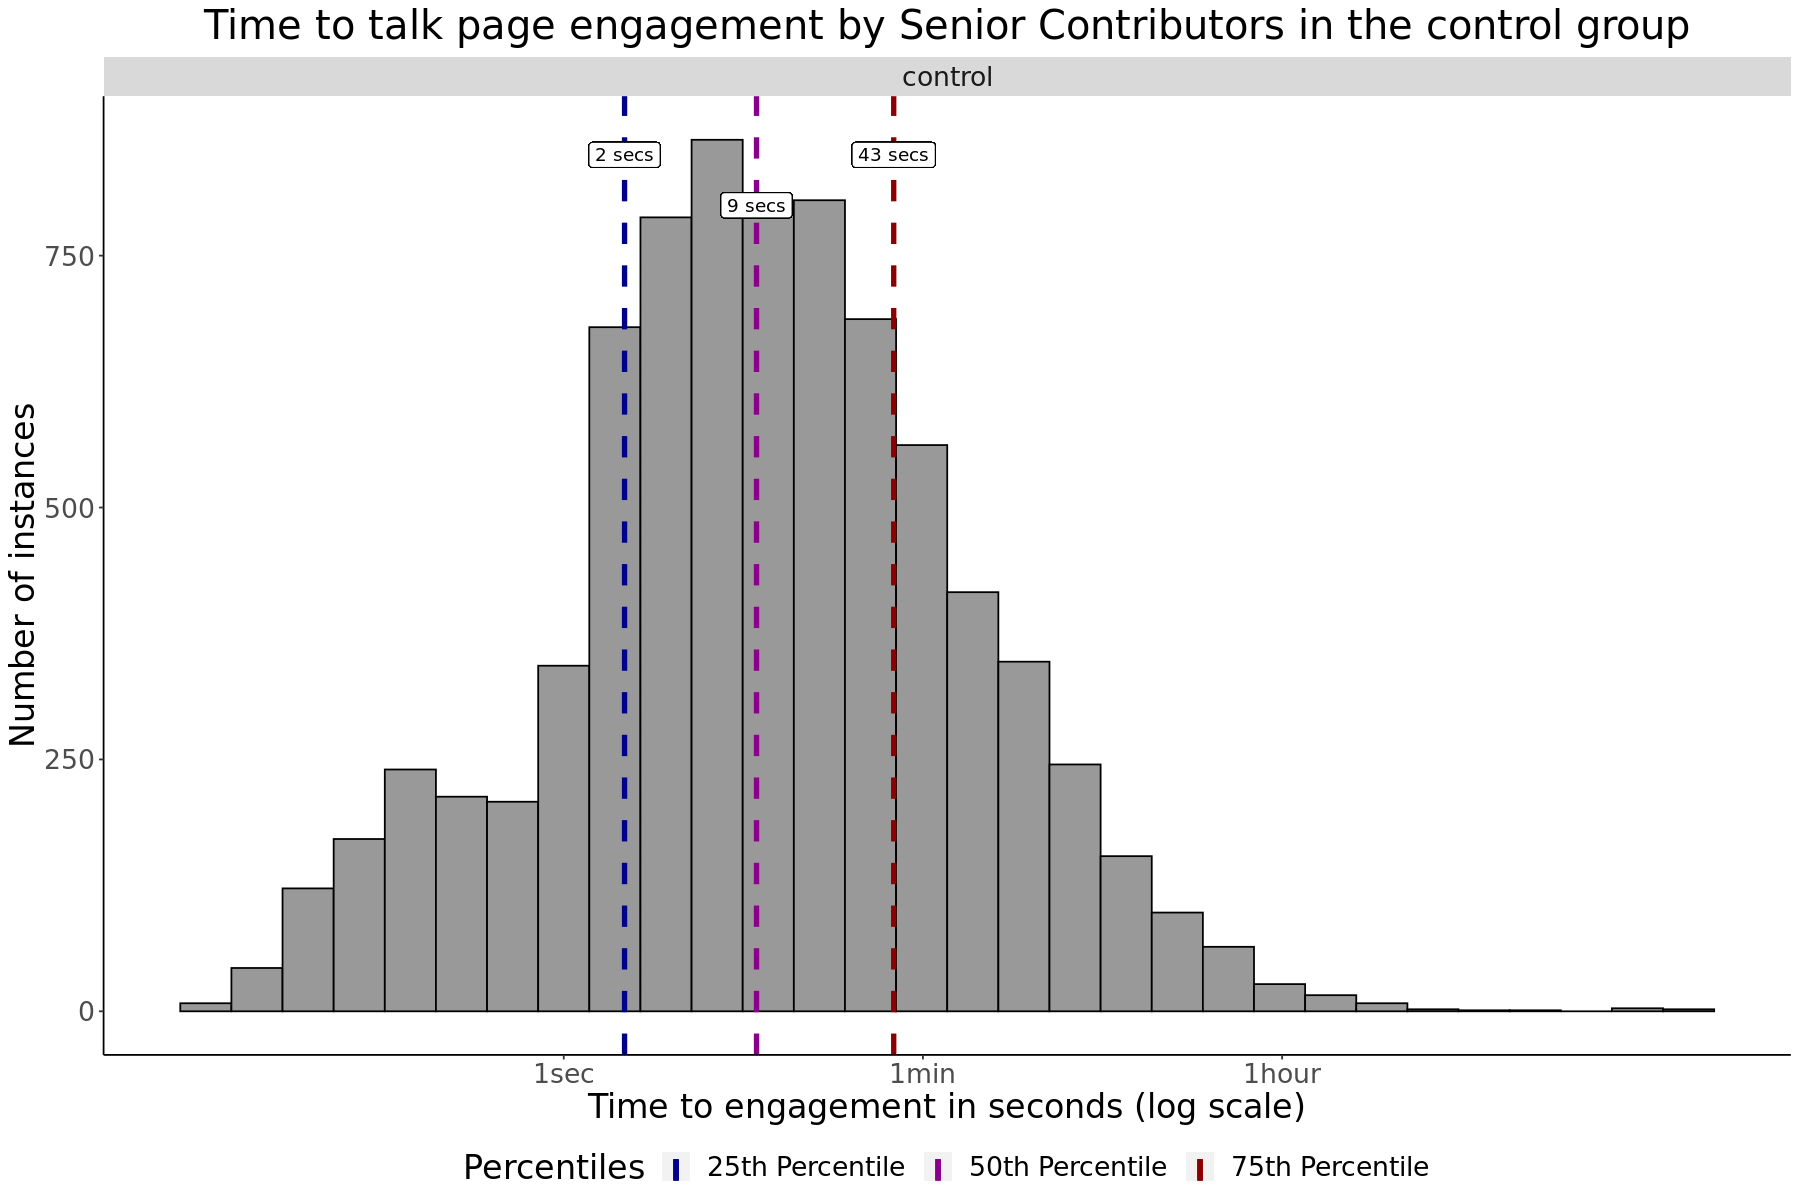

In [65]:
# Create histogram for control group


time_to_engage_histogram_control_sc <- time_to_engage_data_sc %>%
    filter(experiment_group == 'control') %>%
    ggplot(aes(x=duration)) +  #round to nearest minute
    geom_histogram(color = 'black', fill = "#999999") +
    geom_vline(aes(xintercept = control_q_sc[1], color = '25th Percentile'), linetype = 'dashed', size = 1.5) +
     geom_vline(aes(xintercept = control_q_sc[2], color = '50th Percentile'), linetype = 'dashed', size = 1.5) +
    geom_vline(aes(xintercept = control_q_sc[3], color = '75th Percentile'), linetype = 'dashed', size = 1.5) +
      geom_label(aes(x = control_q_sc[1], y =850, label = paste0(control_q_sc[1], " secs"))) +
      geom_label(aes(x = control_q_sc[2], y = 800, label = paste0(control_q_sc[2], " secs"))) +
      geom_label(aes(x = control_q_sc[3], y = 850, label = paste0(control_q_sc[3], " secs"))) +
    facet_wrap(~ experiment_group) +
      scale_x_log10(breaks=c(1,60,3600),labels=c("1sec","1min","1hour")) +
    scale_y_continuous()+
    labs (title = "Time to talk page engagement by Senior Contributors in the control group",
          y = "Number of instances",
         x= "Time to engagement in seconds (log scale)")   + 
    scale_color_manual(name='Percentiles',
                     breaks=c('25th Percentile', '50th Percentile', '75th Percentile'),
                     values=c("25th Percentile" = "darkblue", "50th Percentile" = "darkmagenta", "75th Percentile" = "darkred")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 

time_to_engage_histogram_control_sc

ggsave("Figures/time_to_engage_histogram_control_sc.png",time_to_engage_histogram, width = 16, height = 11, units = "in", dpi = 300)

### Test Group

In [247]:
#quantiles for test group
test_q_sc <- round(quantile(time_to_engage_data_sc$duration[time_to_engage_data_sc$experiment_group == 'test'], probs = c(0.25, 0.5, 0.75), 3))

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 41 rows containing non-finite values (stat_bin).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



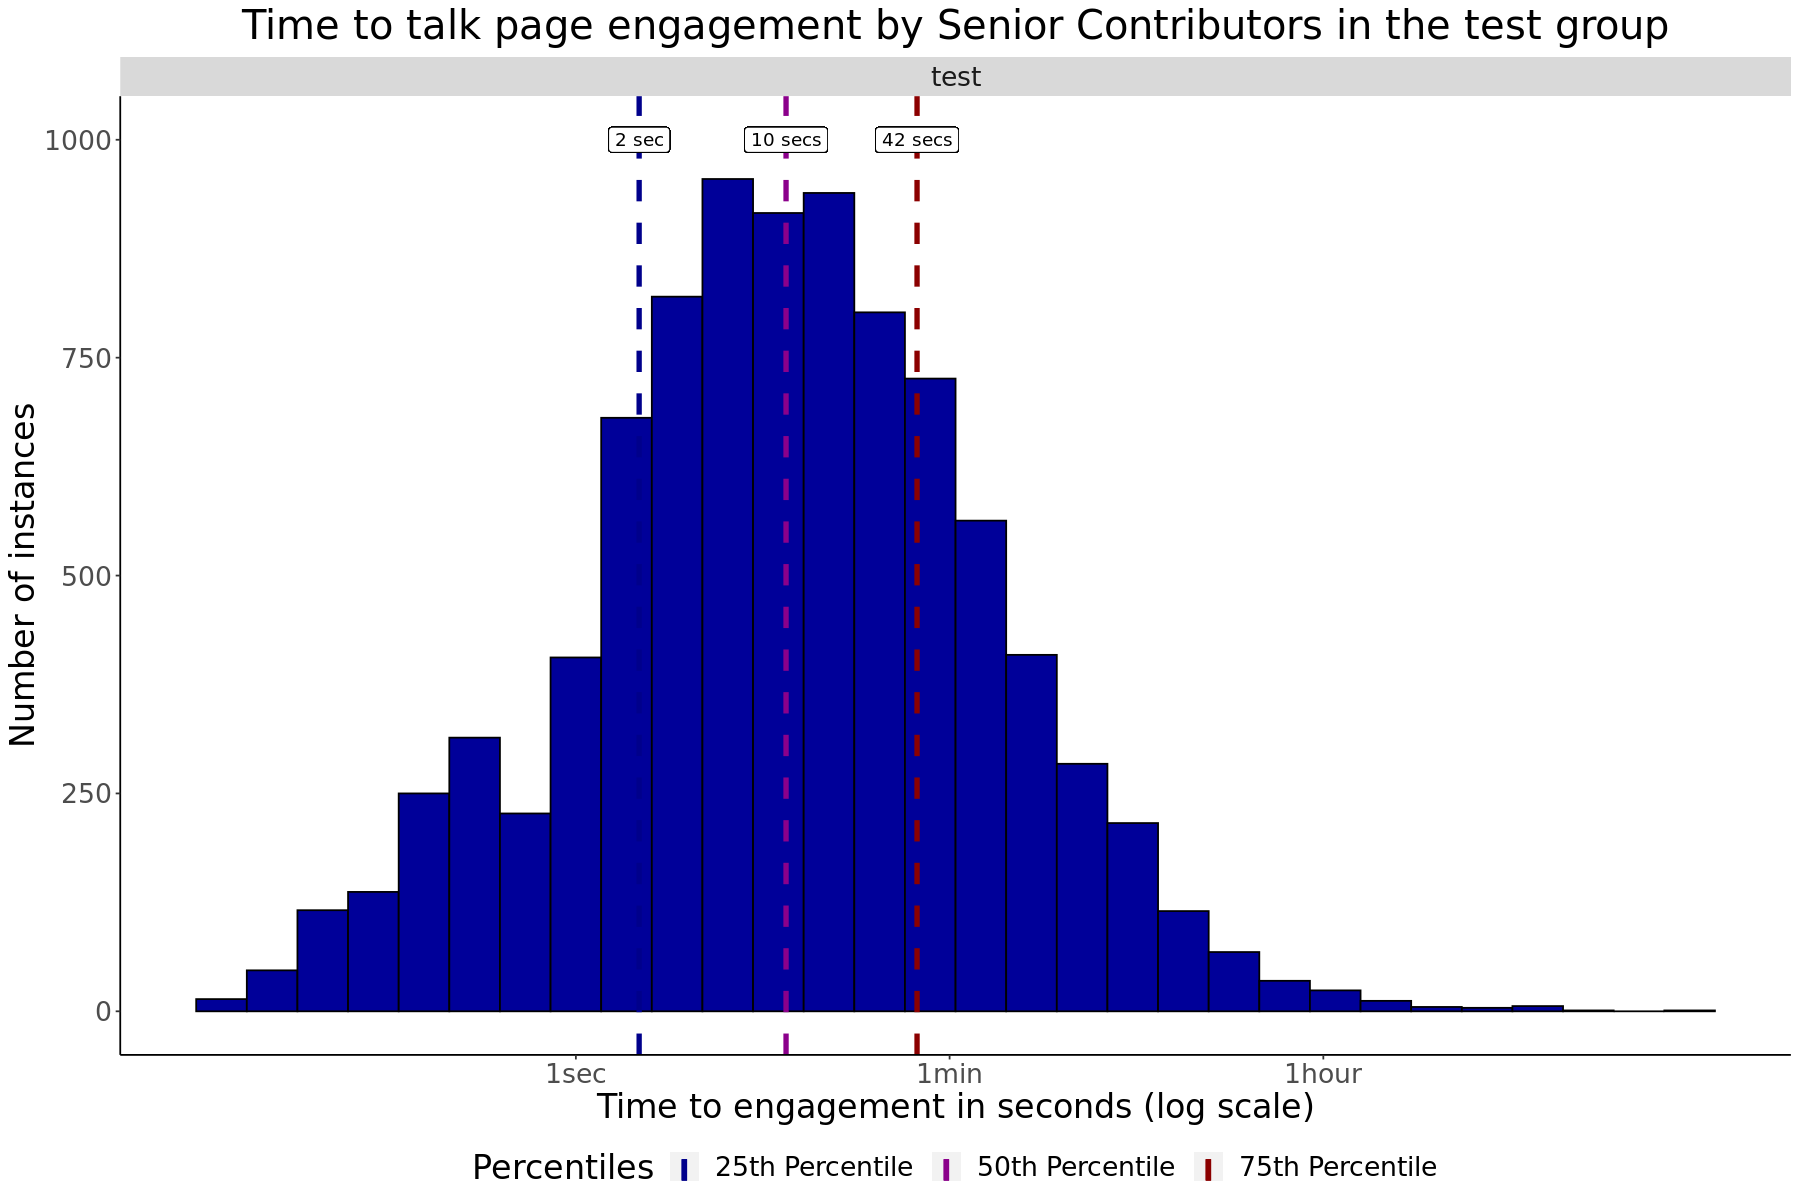

In [253]:
# Create histogram for test group


time_to_engage_histogram_test_sc <- time_to_engage_data_sc %>%
    filter(experiment_group == 'test') %>%
    ggplot(aes(x=duration)) +  #round to nearest minute
    geom_histogram(color = 'black', fill = "#000099") +
    geom_vline(aes(xintercept = test_q_sc[1], color = '25th Percentile'), linetype = 'dashed', size = 1.5) +
     geom_vline(aes(xintercept = test_q_sc[2], color = '50th Percentile'), linetype = 'dashed', size = 1.5) +
    geom_vline(aes(xintercept = test_q_sc[3], color = '75th Percentile'), linetype = 'dashed', size = 1.5) +
      geom_label(aes(x = test_q_sc[1], y =1000, label = paste0(test_q_sc[1], " sec"))) +
      geom_label(aes(x = test_q_sc[2], y = 1000, label = paste0(test_q_sc[2], " secs"))) +
      geom_label(aes(x = test_q_sc[3], y = 1000, label = paste0(test_q_sc[3], " secs"))) +
    facet_wrap(~ experiment_group) +
      scale_x_log10(breaks=c(1,60,3600),labels=c("1sec","1min","1hour")) +
    scale_y_continuous()+
    labs (title = "Time to talk page engagement by Senior Contributors in the test group",
          y = "Number of instances",
         x= "Time to engagement in seconds (log scale)")   + 
    scale_color_manual(name='Percentiles',
                     breaks=c('25th Percentile', '50th Percentile', '75th Percentile'),
                     values=c("25th Percentile" = "darkblue", "50th Percentile" = "darkmagenta", "75th Percentile" = "darkred")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=20),
        legend.position= "bottom",
        axis.line = element_line(colour = "black")) 

time_to_engage_histogram_test_sc

ggsave("Figures/time_to_engage_histogram_test_sc.png",time_to_engage_histogram, width = 16, height = 11, units = "in", dpi = 300)

In [66]:
#find the average time difference

time_to_engage_overall_sc <- time_to_engage_data_sc %>%
    group_by(experiment_group) %>%
      summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
                 duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs")) %>% 
    pivot_wider(names_from = quantile, values_from =  duration)
   

time_to_engage_overall_sc

experiment_group 25%    50%     75%    
1 control          2 secs 9 secs  43 secs
2 test             2 secs 10 secs 42 secs

## By Editor Interface

In [67]:

time_to_engage_interface_sc <- time_to_engage_data_sc %>%
    group_by(experiment_group, workflow) %>%
       summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
                    duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs")) %>% 
    pivot_wider(names_from = quantile, values_from =  duration)
   

time_to_engage_interface_sc

experiment_group workflow       25%    50%     75%    
1 control          new_topic_tool 1 secs 3 secs  12 secs
2 control          reply_tool     6 secs 20 secs 81 secs
3 test             new_topic_tool 1 secs 3 secs  12 secs
4 test             reply_tool     6 secs 21 secs 77 secs

## By Desktop Skin

In [ ]:
time_to_engage_skin_sc <-  time_to_engage_data_sc %>%
    group_by(experiment_group, skin) %>%
      summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
                 duration = paste0(round(quantile(duration, c(0.25, 0.5, 0.75)), 0), " secs")) %>% 
    pivot_wider(names_from = quantile, values_from =  duration)

time_to_engage_skin_sc

experiment_group skin        25%    50%     75%    
1 control          vector      2 secs 8 secs  38 secs
2 control          vector-2022 3 secs 12 secs 53 secs
3 test             vector      2 secs 9 secs  40 secs
4 test             vector-2022 3 secs 11 secs 45 secs

## By Wiki

In [71]:

time_to_engage_wiki_sc <- time_to_engage_data_sc %>%
      group_by(experiment_group, wiki) %>%
    summarise(median_time_to_engage = round(median(duration), 0),
             mean_time_to_engage = round(mean(duration), 0), .groups = 'drop'
             )  %>%
    arrange(wiki)

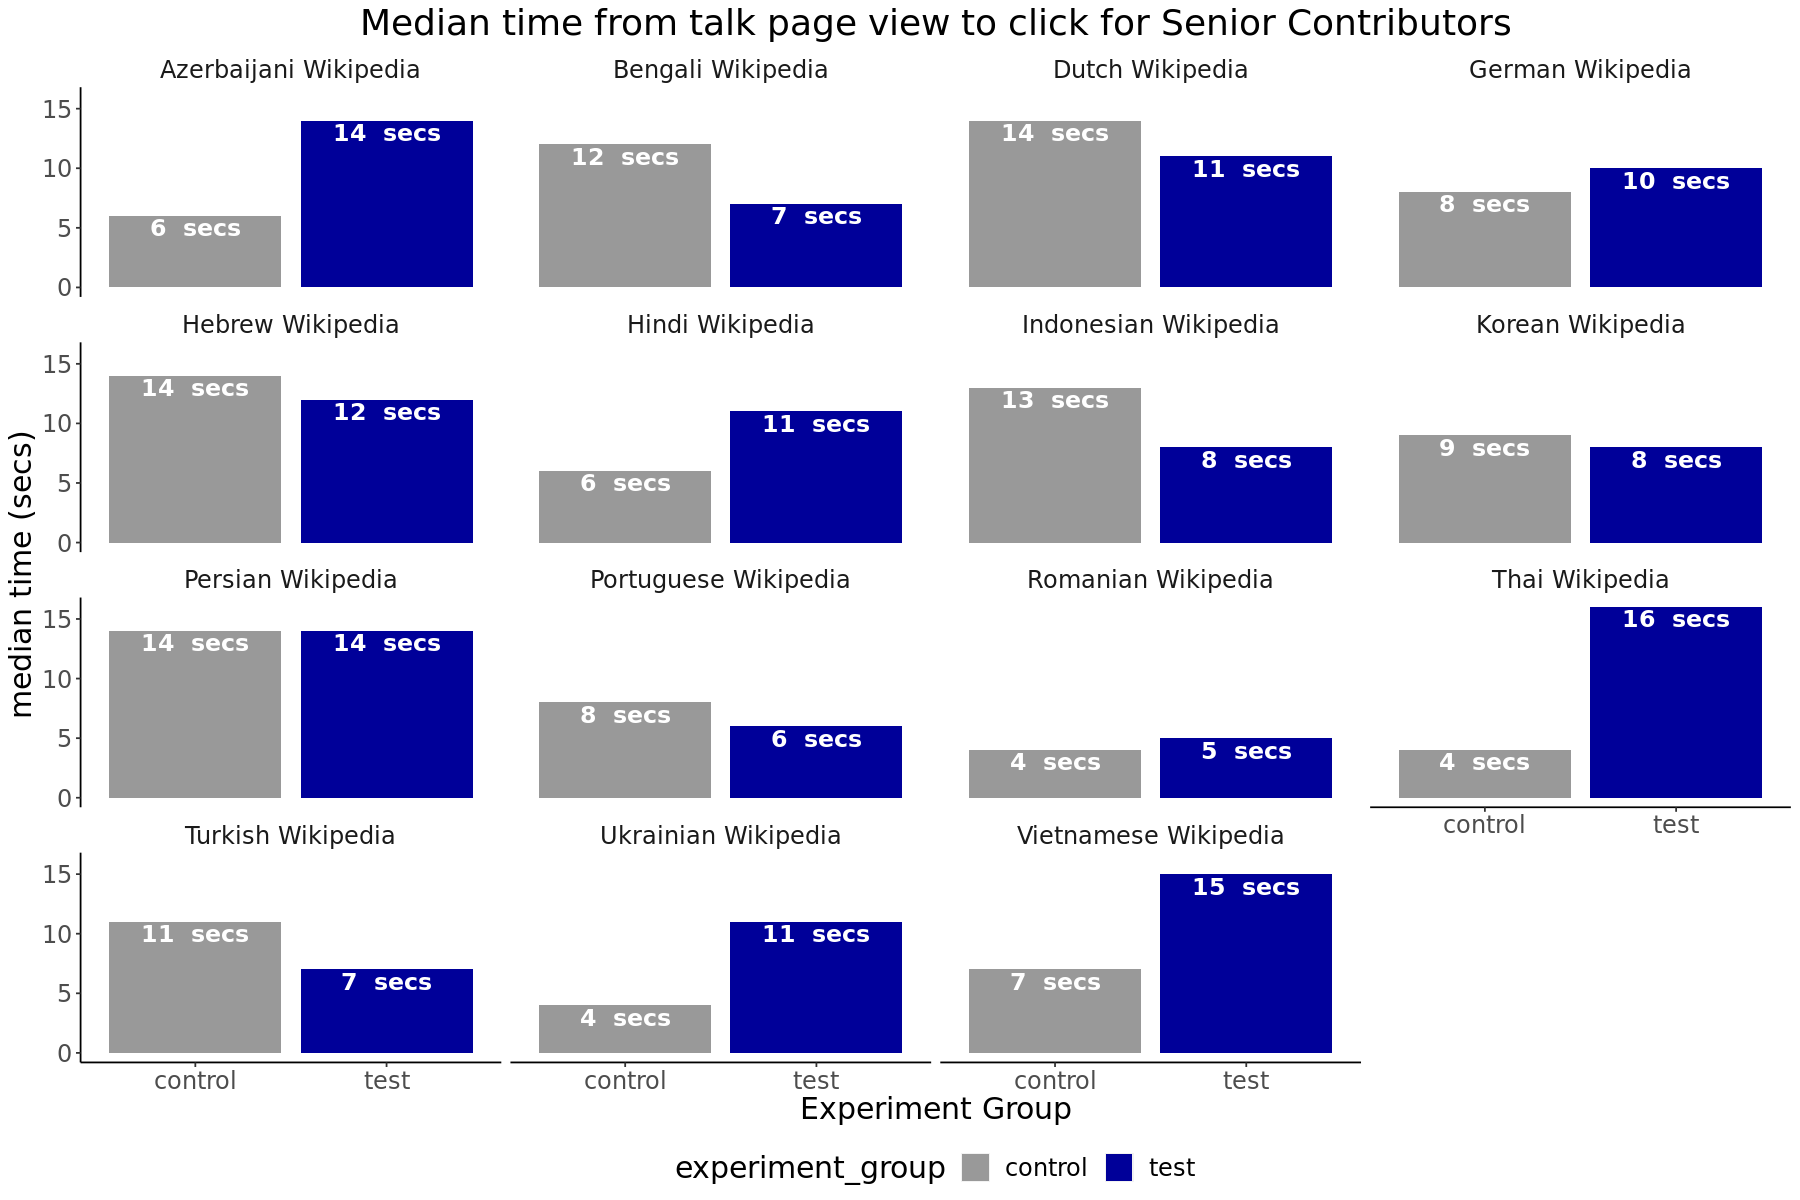

In [72]:

p <- time_to_engage_wiki_sc  %>%
       # filter(wiki %in% c('Vietnamese Wikipedia', 'Ukrainian Wikipedia', 'Turkish Wikipedia', 'Portuguese Wikipedia',
                  #      'Persian Wikipedia', 'Indonesian Wikipedia', 'Hebrew Wikipedia', 'German Wikipedia', 'Dutch Wikipedia'))  %>%
        ggplot(aes(x = experiment_group, y= median_time_to_engage, fill = experiment_group)) +
         geom_col(position = 'dodge') +
            geom_text(aes(label = paste(median_time_to_engage," secs"), fontface=2), vjust=1.2, size = 5, color = "white") +
         facet_wrap(~ wiki) +
        labs (x = "Experiment Group",
              y = "median time (secs)",
             title = "Median time from talk page view to click for Senior Contributors") +
        scale_fill_manual(values= c("#999999", "#000099"))  +
        scale_y_continuous() +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p


ggsave("Figures/time_to_engage_wiki_sc.png", p, width = 10, height = 8, units = "in", dpi = 300) 